# 題目｜直播商品分類挑戰



至少兩種分類方法，其中一種至少要是LLM

- **描述**：我們提供了蝦皮上25萬多個商品的名稱及其對應的大類別及小類別，同學可以利用到目前為止學到的文字探勘的技巧，對蝦皮上的商品名稱先做基本的前處理後，嘗試用任意一種或多種的演算法，對蝦皮的商品建立一個分類模型（大類、小類皆要）。 接著我們提供了直播平台上的商品名稱及販售的直播主，同學可用上面建立的分類模型，預測直播平台上的商品分類，預測完成後，同學須在我們提供的資料右方在新增兩個欄位，分別存放預測出來的大類及小類（若是在蝦皮的類別中找不到合適的分類給的商品，則填入[UNK]）。

- **蝦皮資料集**：共有253,285筆資料，大類有27類，小類有715類。 大類與小類有階層關係，如下圖，「女生包包/精品」又可分為中夾/短夾、手提包、手提斜背筆電包等等。

- **直播平台資料集**：約有1萬8千多筆商品名稱，且沒有標註類別。

# 方法概述

我們首先採用比例抽樣對資料進行抽樣

- 前處理階段，我們分別嘗試了：結巴斷詞、CKIP tagger斷詞、詞性標註、TF-IDF

- 分類模型：樸素貝葉斯、隨機森林、XGBoost、TextCNN

- 大型語言模型：CKIP BERT

最後挑選出幾個表現較佳的模型
分別是
1. 使用 CKIP BERT 對大類進行分類
2. 使用詞性標註留下重要的詞性，作 one-hot encoding，並使用隨機森林進行小類的分類


# 套件

In [ ]:
!pip install -U transformers
!pip install -U ckip-transformers
!pip install zhon
!pip install ckiptagger
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import os
import torch
from transformers import BertTokenizerFast, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
from torch.nn.functional import softmax
import math
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import TransactionEncoder
from zhon.hanzi import punctuation
import string
from ckiptagger import data_utils
from ckiptagger import WS
import jieba

# 資料讀取與抽樣

In [ ]:
# download the file
!gdown --id '18b9F-_rRJIewiExftVNBDIcZ4hsIidfU' --output shopee.csv
# 執行完後，應該可以看到左邊檔案區有這個文件(shopee.csv)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18b9F-_rRJIewiExftVNBDIcZ4hsIidfU
To: /content/shopee.csv
100% 25.8M/25.8M [00:00<00:00, 134MB/s]


In [ ]:
df = pd.read_csv('shopee.csv')
print(df.shape)
df.drop_duplicates(inplace=True) # 原始資料有重複的觀測值，去除重複值
print(df.shape)
df.head()

(253285, 3)
(253188, 3)


,商品名稱,大類,小類
0,PHILIPS 飛利浦 全自動義式咖啡機-EP3246 (金)+湛盧咖啡豆券8張(24包),家用電器,咖啡機與周邊
1,PHILIPS 飛利浦 小旋風電動洗鞋機 (GCA1000),家用電器,其他家電
2,PHILIPS 飛利浦 2021旗艦款八合一乾濕兩用拔刮美體刀 除毛刀 BRE740,美妝保養,除毛器材
3,PHILIPS 飛利浦 電鬍刀刀頭 RQ11,美妝保養,電動刮鬍刀
4,PHILIPS 飛利浦 全自動義式咖啡機-EP3246 (金),家用電器,咖啡機與周邊


In [ ]:
df.nunique() # 有重複的商品名稱，且不同大類裡面有同樣的小類名稱

商品名稱    253072
大類          27
小類         632
dtype: int64

In [ ]:
df[['大類','小類']].value_counts()

大類       小類  
愛好與收藏品   公仔      5805
女生衣著     T恤      4135
男生衣著     T恤      3778
母嬰用品     積木玩具    3572
愛好與收藏品   組裝模型    3477
                 ... 
手機平板與周邊  電池         3
嬰幼兒童裝童鞋  戒指         3
         耳環         2
         皮帶         2
手錶       其他         1
Length: 715, dtype: int64

In [ ]:
# 新增一個欄位，方便建模型使用
df['大類-小類'] = df['大類']+"-"+df['小類']
df.head()

,商品名稱,大類,小類,大類-小類
0,PHILIPS 飛利浦 全自動義式咖啡機-EP3246 (金)+湛盧咖啡豆券8張(24包),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
1,PHILIPS 飛利浦 小旋風電動洗鞋機 (GCA1000),家用電器,其他家電,家用電器-其他家電
2,PHILIPS 飛利浦 2021旗艦款八合一乾濕兩用拔刮美體刀 除毛刀 BRE740,美妝保養,除毛器材,美妝保養-除毛器材
3,PHILIPS 飛利浦 電鬍刀刀頭 RQ11,美妝保養,電動刮鬍刀,美妝保養-電動刮鬍刀
4,PHILIPS 飛利浦 全自動義式咖啡機-EP3246 (金),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊


In [ ]:
# 分層隨機抽樣(3%)
random.seed(2023) # 設定隨機種子，確保每次執行都是一樣的結果
df_sample = pd.DataFrame()
for class_1 in df['大類'].drop_duplicates():
    df_sub = df[df['大類']==class_1]
    for class_2 in df_sub['小類'].drop_duplicates():
        df_sub2 = df_sub[df_sub['小類']==class_2]
        if df_sub2.shape[0]*0.03 <= 1: # 樣本數太少(<=33)就全抽
            df_sample = pd.concat([df_sample, df_sub2], axis=0)
        else:
            df_sample = pd.concat([df_sample,
                                   df_sub2.iloc[random.sample([x for x in range(df_sub2.shape[0])], k=math.ceil(df_sub2.shape[0]*0.03)),]], axis=0)
print(df_sample.shape)
df_sample.reset_index(inplace=True)
df_sample

(8255, 4)


,index,商品名稱,大類,小類,大類-小類
0,27187,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
1,143980,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
2,27640,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
3,206417,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
4,28781,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電
...,...,...,...,...,...
8250,135978,【Daniel Wellington】Petite 32mm玫瑰金米蘭錶 X 經典簡約玫瑰金...,手錶,手錶錶帶,手錶-手錶錶帶
8251,97576,KENNETH COLE 紐約設計精品錶 KC50917006 鏤空機械錶 自動上鍊 真皮錶...,手錶,手錶錶帶,手錶-手錶錶帶
8252,135876,【Daniel Wellington】Quadro Coral 10mm粉珊瑚織紋錶帶 DW錶帶,手錶,手錶錶帶,手錶-手錶錶帶
8253,124698,【SWATCH】New Gent 原創系列手錶BLACK BLUR 迷濛黑(41mm) SU...,手錶,手錶錶帶,手錶-手錶錶帶


In [ ]:
df_sample.drop(columns=['index'], inplace=True)
df_sample.to_csv("df_sample.csv", index=False) # 輸出抽樣後的資料，方便後續步驟的進行

# 大類分類模型：CKIP Bert

## 建模

In [ ]:
df_sample = pd.read_csv("df_sample.csv")

In [ ]:
product = df_sample['商品名稱'].to_numpy()
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample['大類'].to_numpy())

# split the data
X_train, X_test, y_train, y_test = train_test_split(product, class_1, test_size=0.2, random_state=42)

In [ ]:
# 確保訓練資料每個類都有
print(df_sample['大類'].nunique(),
      len(np.unique(y_train)),
      len(np.unique(y_test)))

27 27 27


In [ ]:
# load pre-trained BERT model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForSequenceClassification.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(np.unique(y_train)))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# BERT input conversion
# 將文本數據轉換為適用於BERT模型的輸入格式，以便進行訓練和推理
device = torch.device('cuda')
model.to(device)

def tokenize_reviews(reviews, labels):
    input_ids = []
    attention_masks = []

    for review in reviews:
        encoded_dict = tokenizer.encode_plus( # 將文本轉換為BERT可接受的編碼格式
            review, # 要處理的文本
            add_special_tokens=True, # 特殊tokens，如[CLS]和[SEP]
            max_length=128,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt' # 輸出PyTorch張量
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels
    # 函數輸出的值可直接用於BERT模型進行文本分類

In [ ]:
# BERT fine-tuning
# convert data to PyTorch tensors
input_ids, attention_masks, labels = tokenize_reviews(X_train, y_train)

# create DataLoader for training data
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(dataset, batch_size=15, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [ ]:
# 訓練模型
for epoch in range(epochs): # 模型訓練將在多個時期中進行
  model.train() # 將模型切換到訓練模式。在訓練模式下，模型會計算梯度，並在反向傳播時更新模型參數
  for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
# 5m

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# evaluation
model.eval() # set to evaluation mode
test_input_ids, test_attention_masks, test_labels = tokenize_reviews(X_test, y_test) # 將文本數據轉換為適用於BERT模型的輸入格式
test_input_ids, test_attention_masks, test_labels = test_input_ids.to(device), test_attention_masks.to(device),test_labels.to(device)

with torch.no_grad():
  logits = model(test_input_ids, attention_mask=test_attention_masks)
  probabilities = softmax(logits.logits, dim=1)  # 使用softmax取得概率分布
  max_probabilities = np.max(probabilities.cpu().numpy(), axis=1)
  # threshold = 0.5
  # predicted_labels = np.where(max_probabilities >= threshold, np.argmax(logits.logits.cpu().numpy(), axis=1), '[UNK]')
predicted_labels = np.argmax(logits.logits.cpu().numpy(), axis=1)

In [ ]:
# 因為預測階段會有 CUDA out of memory 的問題，因此上面的模型、tokenizer要先存下來
model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

In [ ]:
print(predicted_labels)
print(label_encoder.inverse_transform(predicted_labels))
print(len(set(predicted_labels)))

[21 24  3 ...  1 21  9]
['男生衣著' '美妝保養' '女鞋' ... '女生包包/精品' '男生衣著' '愛好與收藏品']
26


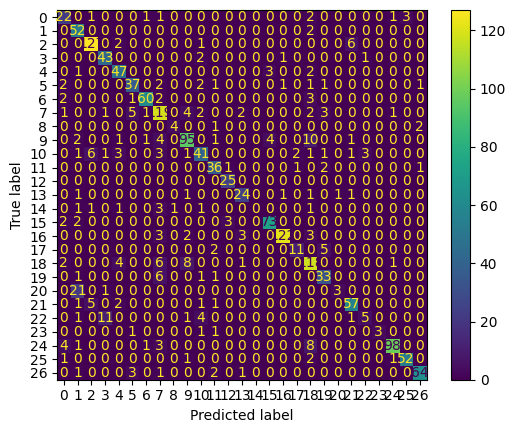

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.8304
precision,0.8315
recall,0.8304
f1_score,0.8232


In [ ]:
# 輸出模型的參數數量
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]

model_params =get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102288411
線性分類器的參數量：20763



In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UNK
threshold = 0.4
result_df = pd.DataFrame({'product': X_test,
                          'class_1': label_encoder.inverse_transform(y_test),
                          'pred_class_1': label_encoder.inverse_transform(predicted_labels),
                          'max_prob': max_probabilities})
result_df['filter_pred_class_1'] = result_df.apply(lambda row: row['pred_class_1'] if row['max_prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
0,Lee 涼感藝術字體短袖T恤 男 黑 Urban Riders 玉石科技 210148K11,男生衣著,男生衣著,0.712740,男生衣著
1,Neogence霓淨思玻尿酸保濕潤澤霜50ml,美妝保養,美妝保養,0.947348,美妝保養
2,amai 韓系簡約方頭後拉鍊皮革襪靴 短靴 粗跟 深棕 GB604CF,女鞋,女鞋,0.864253,女鞋
3,【出清】QUEENSHOP_ F 童裝 親子系列翻蓋口袋造型燈心絨襯衫 S-L 現+...,嬰幼兒童裝童鞋,嬰幼兒童裝童鞋,0.968122,嬰幼兒童裝童鞋
4,【小熊維尼】 - 維尼夾式組合/跳跳虎款,時尚配件,女生包包/精品,0.522365,女生包包/精品
...,...,...,...,...,...
1646,BANDAI 萬代 HG 1/144 機動戰士鋼彈 雷霆宙域戰線 薩克I 舊薩克 組裝模型 ...,愛好與收藏品,愛好與收藏品,0.965548,愛好與收藏品
1647,我所嚮往的生活文明 (誠品獨家親簽版)/嚴長壽 eslite誠品,書籍及雜誌期刊,書籍及雜誌期刊,0.980466,書籍及雜誌期刊
1648,BEN DAVIS ORIGINAL WAIST BAG 雙層 腰包 側背包 白標 猿人 5...,男生包包,女生包包/精品,0.640873,女生包包/精品
1649,Levis 上寬下窄 502Taper牛仔褲 / 中藍刷白 / 彈性布料 男款-熱賣單品 2...,男生衣著,男生衣著,0.963205,男生衣著


In [ ]:
result_df[result_df['class_1'] != result_df['pred_class_1']] # 第三個是預測的才正確，原始被分的類別應有誤

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
4,【小熊維尼】 - 維尼夾式組合/跳跳虎款,時尚配件,女生包包/精品,0.522365,女生包包/精品
12,CATISS【三代】貓掌護唇膏-三花莓果(潤粉色),美妝保養,母嬰用品,0.465331,母嬰用品
18,貼身寶貝淑女型免洗褲M 5入,旅行相關用品/行李箱,嬰幼兒童裝童鞋,0.942537,嬰幼兒童裝童鞋
22,酷咕鴨 KU.KU . 亮亮單結帽,母嬰用品,嬰幼兒童裝童鞋,0.930522,嬰幼兒童裝童鞋
56,PUMA PHASE腰包 帆布包 - 07690844,男生包包,女生包包/精品,0.652326,女生包包/精品
...,...,...,...,...,...
1622,[曼迪] 犬夜叉-小提袋-蹦,愛好與收藏品,寵物,0.326886,UNK
1631,BLUE WAY ET BOîTE 箱子-黑膠娃娃雙人華爾滋短TEE (藏青),女生衣著,嬰幼兒童裝童鞋,0.933444,嬰幼兒童裝童鞋
1636,Lovito 運動素色緊身繫帶T恤V領短袖上衣 L03012 (灰色),戶外與運動用品,女生衣著,0.787031,女生衣著
1643,【plain-me】中信兄弟 X plain-me 吸濕快乾拼接TEE CRV0081-22...,男生衣著,手機平板與周邊,0.314077,UNK


In [ ]:
# 總共篩選出44個UNK，其中，280個被預測錯誤的標籤中，有31個成功預測為UNK
print(sum(result_df['filter_pred_class_1']=='UNK'),
      '\n',
      sum(result_df[result_df['class_1'] != result_df['pred_class_1']]['filter_pred_class_1']=='UNK'))

44 
 31


In [ ]:
# 將accuracy這些整理成dataframe（加入UNK後）
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_1'], result_df['filter_pred_class_1']),
                                    precision_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    recall_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    f1_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # precision會提高

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.8225
precision,0.8490
recall,0.8225
f1_score,0.8253


## 預測 Jambo 資料

In [ ]:
# 讀取Jambo資料
df_jambo2 = pd.read_csv('jambo_2.csv') # 已簽署保密協議，無法提供

In [ ]:
print(df_jambo2.shape)
df_jambo2.head()

(18752, 3)


,channel_name,商品id,商品名稱
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3


In [ ]:
# 把前面存的 model 跟 tokenizer load 進來
device = torch.device('cuda')
loaded_model = AutoModelForSequenceClassification.from_pretrained("model")
loaded_tokenizer = BertTokenizerFast.from_pretrained("tokenizer")
loaded_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# 因設備限制，每次預測2000筆jambo商品（避免evaluation時cuda out of memory）
new_data = df_jambo2['商品名稱'][18000:].tolist()
tokenized_new_data = loaded_tokenizer(new_data, padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized_new_data = {key: value.to(device) for key, value in tokenized_new_data.items()}

# 預測大類標籤與機率
with torch.no_grad():
    logits = loaded_model(**tokenized_new_data)
    probabilities = softmax(logits.logits, dim=1)
    max_probabilities = np.max(probabilities.cpu().numpy(), axis=1)
    predicted_labels = np.argmax(logits.logits.cpu().numpy(), axis=1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 輸出模型的參數數量
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]

model_params =get_learnable_params(loaded_model)
clf_params = get_learnable_params(loaded_model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102288411
線性分類器的參數量：20763



In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UNK
df_sample = pd.read_csv("df_sample.csv")
label_encoder = LabelEncoder()
label_encoder.fit_transform(df_sample['大類'].to_numpy())

threshold = 0.4
result_df = pd.DataFrame({'product': new_data,
                          'pred_class_1': label_encoder.inverse_transform(predicted_labels),
                          'prob': max_probabilities})
result_df['filter_pred_class_1'] = result_df.apply(lambda row: row['pred_class_1'] if row['prob'] > threshold else 'UNK', axis=1)
result_df

,product,pred_class_1,prob,filter_pred_class_1
0,秀炮 0705 A12-(2罐)生薑韌髮頭皮洗髮精 (760ml)*2,美妝保養,0.977315,美妝保養
1,公主 0312 G07-(3盒)cab's 地龍傳奇(紅蚯蚓雙激酶膠囊)*3,母嬰用品,0.543453,母嬰用品
2,大師兄 1030 A39-過炭酸na 活氧酵素 450g*1-結單缺貨刪單不通知,美食、伴手禮,0.696229,美食、伴手禮
3,秀炮 0322 A02-Car Holder手機架*1-結單缺貨刪單不通知,手機平板與周邊,0.887755,手機平板與周邊
4,888 0302 A13-(5盒)兒童口嚼碇(60粒/盒)-葉黃素*5,保健,0.424592,保健
...,...,...,...,...
747,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,保健,0.776251,保健
748,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,美妝保養,0.974126,美妝保養
749,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,美食、伴手禮,0.555155,美食、伴手禮
750,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,美妝保養,0.895431,美妝保養


In [ ]:
result_df.to_csv("Label_result_df_10.csv", index=False, encoding="utf-8")

## Jambo預測結果分析

In [ ]:
# result_df = pd.concat([pd.read_csv('Label_result_df_1.csv'),
#                        pd.read_csv('Label_result_df_2.csv'),
#                        pd.read_csv('Label_result_df_3.csv'),
#                        pd.read_csv('Label_result_df_4.csv'),
#                        pd.read_csv('Label_result_df_5.csv'),
#                        pd.read_csv('Label_result_df_6.csv'),
#                        pd.read_csv('Label_result_df_7.csv'),
#                        pd.read_csv('Label_result_df_8.csv'),
#                        pd.read_csv('Label_result_df_9.csv'),
#                        pd.read_csv('Label_result_df_10.csv')], axis=0)
# result_df.to_csv("Label_result_df.csv", index=False, encoding="utf-8")
result_df = pd.read_csv("Label_result_df.csv")
print(result_df.shape)
result_df.head()

(18752, 4)


,product,pred_class_1,prob,filter_pred_class_1
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,0.803048,家用電器
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,居家生活,0.581099,居家生活
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,居家生活,0.544095,居家生活
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,居家生活,0.931380,居家生活
4,888 0110 A64-(3袋)環保垃圾袋400G*3,居家生活,0.823938,居家生活


In [ ]:
result_df['pred_class_1'].value_counts()

居家生活       3890
美食、伴手禮     3051
美妝保養       2918
保健         2204
男生衣著        725
家用電器        684
愛好與收藏品      674
汽車類         655
手機平板與周邊     556
母嬰用品        503
女生包包/精品     467
女生衣著        386
時尚配件        348
寵物          338
女鞋          215
嬰幼兒童裝童鞋     195
電腦與周邊配件     173
書籍及雜誌期刊     169
影音          146
手錶          100
相機&空拍機       90
文具、美術用具      68
男生包包         65
戶外與運動用品      48
男鞋           45
機車類          39
Name: pred_class_1, dtype: int64

In [ ]:
# prob超過50%的，除了 index 5 的蓮蓬頭被歸類為汽車類外，其他看起來預測皆正確
result_df.loc[result_df.prob>0.5,].head(10)

,product,pred_class_1,prob,filter_pred_class_1
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,0.803048,家用電器
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,居家生活,0.581099,居家生活
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,居家生活,0.544095,居家生活
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,居家生活,0.931380,居家生活
4,888 0110 A64-(3袋)環保垃圾袋400G*3,居家生活,0.823938,居家生活
5,畢哥 0523 B21-(4件組)Cab's SHOWERHEAD 黑金一鍵止水萬向蓮蓬頭*...,汽車類,0.514678,汽車類
6,第 087 標(9/25)304不銹鋼蓮花蒸架(底部有點利.可以接受再下單)一個50元,居家生活,0.741029,居家生活
7,畢哥 0323 B02-美國DORCO 柔軟細刷毛牙刷 (12PC/盒)*1,保健,0.933291,保健
8,舊三郎 0330 A04-公主派對 女神膠原蛋白飲(24入/箱)*1,美食、伴手禮,0.899768,美食、伴手禮
9,🅿西班牙純種伊比利梅花豬*1公斤(肉片/兩盒),美食、伴手禮,0.540051,美食、伴手禮


probability 超過 50% 的僅有 15434 筆 (82.31%)
probability 超過 40% 的僅有 16965 筆 (90.47%)


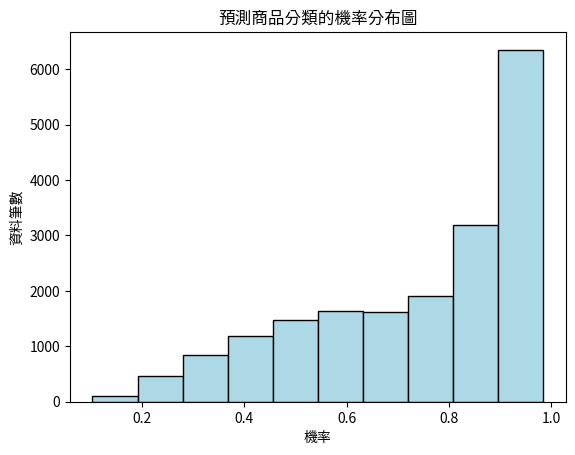

In [ ]:
plt.hist(result_df.prob, color='lightblue', edgecolor='black')
plt.xlabel('機率')
plt.ylabel('資料筆數')
plt.title('預測商品分類的機率分布圖')

print('probability 超過 50% 的有 ',len(result_df.loc[result_df.prob>0.5,]),' 筆 (',round((len(result_df.loc[result_df.prob>0.5,])/len(result_df))*100,2),'%)',sep='')
print('probability 超過 40% 的有 ',len(result_df.loc[result_df.prob>0.4,]),' 筆 (',round((len(result_df.loc[result_df.prob>0.4,])/len(result_df))*100,2),'%)',sep='')
# 機率超過50%的有15434筆(82.31%)
# 只有不到兩成商品的預測機率小於50%，整體表現看起來不錯

In [ ]:
result_df.loc[(result_df['prob'] < 0.5) & (result_df['prob'] > 0.4), :].head(20)
# 觀察probability介於0.4-0.5的資料，發現即使probability不高，但預測的分類結果幾乎正確

,product,pred_class_1,prob,filter_pred_class_1
16,888 1009 A05-KING KONG金剛王中王充電線(TYPE-C) 3A*1,手機平板與周邊,0.443023,手機平板與周邊
20,888 0522 A10-老闆亂丟沐浴10件組,母嬰用品,0.460072,母嬰用品
37,888 0426 B03-(2罐)威飄 迅速 COOL降溫劑 (360ML)*2,居家生活,0.444575,居家生活
74,叫賣 0311 A06-(2罐)日本味王暢快人生青蘋果/覆盆莓 精華版(60g/瓶/盒)(隨...,保健,0.486486,保健
95,第 011 標(5/29)史努比行動電源10400毫安培(顏色隨機)一顆388元,電腦與周邊配件,0.427114,電腦與周邊配件
104,(闆)舊三郎 0819 A07-(限+1)(7盒)PRINCESS PARTY 葉黃素膠囊P...,美食、伴手禮,0.443422,美食、伴手禮
105,叫賣 0312 C15-按摩-(刮痧儀)*1,美妝保養,0.441818,美妝保養
111,(闆)888 1203 A17-(6盒)PRINCESS PARTY 葉黃素膠囊PRLS綠蜂...,保健,0.430498,保健
112,888 0203 A13-(10個)（-濾心-） 黑金一鍵止水萬向蓮蓬頭*10,居家生活,0.499131,居家生活
113,第 001 標 (11/10) 暖暖包5入 99$,居家生活,0.436988,居家生活


In [ ]:
result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2), :].head(20)
# 觀察probability介於0.2-0.4的資料，發現有果膠、糖果被分到「愛好與收藏品」，長袖被分到「書籍及雜誌期刊」，「寵物」出現擴香等

,product,pred_class_1,prob,filter_pred_class_1
10,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,美妝保養,0.225520,UNK
24,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,0.219548,UNK
28,【商城】DAN D PAK綜合果乾堅果糖170G,愛好與收藏品,0.334459,UNK
29,888 0208 A20-(3件組)KAFEN芬芳去味噴霧(大)(100ML)*2+KAFE...,美妝保養,0.371332,UNK
31,公主 0614 A08-(限+2)防護外套*2(80kg內/男女都可穿)\t\t\t\t\t...,男生衣著,0.375696,UNK
52,888 0423 A07-(14件)公主派對。雙龍鴕鳥精膠囊 (30顆/盒)*13+Fasc...,保健,0.232781,UNK
70,公主 0603 H02-(限+5)手持非接觸測溫槍*1($價格後台看),居家生活,0.243032,UNK
91,(活動4/4)KENZO黃虎手拿包,愛好與收藏品,0.203974,UNK
106,(闆)888 0105 A08-(3罐)多用途添加劑120ML*3,居家生活,0.295288,UNK
107,迪士尼天絲柔軟豆豆毯(美人魚/維尼/瑪麗貓/奇奇蒂蒂/小飛象),母嬰用品,0.389365,UNK


In [ ]:
result_df.loc[(result_df['prob'] < 0.4), :].head(20)
# 觀察probability低於0.4的資料，發現許多商品名稱較奇特有創意，可能較難一眼辨別該商品用途
# ex.Camu Camu卡姆卡姆BB美妍Plus、魔法西施泡泡染

,product,pred_class_1,prob,filter_pred_class_1
10,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,美妝保養,0.225520,UNK
24,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,0.219548,UNK
28,【商城】DAN D PAK綜合果乾堅果糖170G,愛好與收藏品,0.334459,UNK
29,888 0208 A20-(3件組)KAFEN芬芳去味噴霧(大)(100ML)*2+KAFE...,美妝保養,0.371332,UNK
31,公主 0614 A08-(限+2)防護外套*2(80kg內/男女都可穿)\t\t\t\t\t...,男生衣著,0.375696,UNK
44,畢哥 0806 A31-(4個)無痕掛勾(6個/卡)*4,愛好與收藏品,0.183126,UNK
52,888 0423 A07-(14件)公主派對。雙龍鴕鳥精膠囊 (30顆/盒)*13+Fasc...,保健,0.232781,UNK
70,公主 0603 H02-(限+5)手持非接觸測溫槍*1($價格後台看),居家生活,0.243032,UNK
80,大師兄 0612 A02-護目鏡(顏色隨機)*1 限+1---刪單不通知,保健,0.166250,UNK
91,(活動4/4)KENZO黃虎手拿包,愛好與收藏品,0.203974,UNK


In [ ]:
result_df.loc[(result_df['prob'] < 0.4) & (result_df['pred_class_1']=='愛好與收藏品'), :].head(20)
# probability低於0.4的商品被分類為「愛好與收藏品」的數量佔第二多（最多的是居家生活，但分類看起來沒什麼問題）
# 發現被分為這類的商品，種類較多較雜，錯誤率較高，其中包含了許多保健食品、美妝保養相關用品

,product,pred_class_1,prob,filter_pred_class_1
24,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,0.219548,UNK
28,【商城】DAN D PAK綜合果乾堅果糖170G,愛好與收藏品,0.334459,UNK
44,畢哥 0806 A31-(4個)無痕掛勾(6個/卡)*4,愛好與收藏品,0.183126,UNK
91,(活動4/4)KENZO黃虎手拿包,愛好與收藏品,0.203974,UNK
210,北臉綠拖NS98M20T,愛好與收藏品,0.284359,UNK
437,新三郎 0413 A06-吸盤摺疊化妝鏡*1,愛好與收藏品,0.293025,UNK
485,公主 0222 A15-無痕雙頭掛勾 (顏色隨機)*1-結單缺貨刪單不通知,愛好與收藏品,0.302978,UNK
560,叫賣 0719 2980-感恩福箱9件組,愛好與收藏品,0.378579,UNK
588,叫賣 0810 A23-黑梳子*1,愛好與收藏品,0.371587,UNK
636,叫賣 0421 A17-(14件組)公主派對NMN活力膠囊(30粒/盒)*12+鈦赫茲項鍊+...,愛好與收藏品,0.369317,UNK


In [ ]:
result_df.loc[(result_df['pred_class_1']=='手錶'), :].head(20)
# 另外也發現在手錶這個分類裡，probability不是很高就是很低，且probability很低的商品幾乎都是「皮帶」
# 推測可能是因為有些手錶名稱包含「皮革錶、錶帶」等字眼，讓「皮帶」被分到這一類

,product,pred_class_1,prob,filter_pred_class_1
98,秀炮 0530 A04-SMART WATCH智能手錶HW22+五色錶帶(紅、粉、淡藍、灰、...,手錶,0.612507,手錶
150,第 073 標(4/21)石英機芯懷錶(款式隨機)一個92元,手錶,0.886665,手錶
190,第 033 標 (8/8)MK皮帶禮盒組,手錶,0.209396,UNK
260,第080標(4/6)KANGOL米蘭錶(金)一支852元,手錶,0.894113,手錶
280,秀炮 0605 A02-SMART WATCH智能手錶HW22+五色錶帶(紅、粉、淡藍、灰、...,手錶,0.611649,手錶
532,EA霸氣王者三眼計時黑錶(2453),手錶,0.901037,手錶
821,新三郎 0420 A14-(13件組)公主派對超皙錠(30入/盒)*6+韓國低分子海洋膠原蛋...,手錶,0.492604,手錶
992,舊三郎 0416 A01-(1個)Smart Watch 智能手錶(顏色隨機)*1(+3顏色...,手錶,0.670461,手錶
1103,COACH滿版錶帶水鑽錶(5315藍/5308咖),手錶,0.899379,手錶
1244,【商城】EA 金面簡約手錶 AR11127,手錶,0.867160,手錶


# 小類分類模型：隨機森林



因為Bert接受的標籤數量最多512個，小類無法使用，要換別的模型，否則會一直出現error。

source: https://stackoverflow.com/questions/51691563/cuda-runtime-error-59-device-side-assert-triggered

In [ ]:
df_sample = pd.read_csv("df_sample.csv")
df_sample.head()

,商品名稱,大類,小類,大類-小類
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電


## 斷詞與詞性標註

In [ ]:
ws_driver = CkipWordSegmenter(model="bert-base")
pos_driver = CkipPosTagger(model="bert-base")
ws_driver = CkipWordSegmenter(device=0) # Use GPU:0

In [ ]:
# 測試前五筆
ws = ws_driver(df_sample['商品名稱'][:5])
pos = pos_driver(ws)
del_pos = ['Neu','Nf','COLONCATEGORY','COMMACATEGORY','DASHCATEGORY','DOTCATEGORY','ETCCATEGORY','EXCLAMATIONCATEGORY','PARENTHESISCATEGORY','PAUSECATEGORY','PERIODCATEGORY','QUESTIONCATEGORY','SEMICOLONCATEGORY','SPCHANGECATEGORY','WHITESPACE']
# 詞性列表: https://ckip.iis.sinica.edu.tw/service/transformers/
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   clean = []
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      if word_pos not in del_pos:
         word_ws_c = re.sub(" ", "", word_ws) # 因為有些斷詞結果會出現空白，不希望出現所以替代掉
         # clean.append(word_ws_c)
         res.append(f"{word_ws_c}#{word_pos}")
   return " ".join(res) # [" ".join(clean), " ".join(res)]

for sentence, sentence_ws, sentence_pos in zip(df_sample['商品名稱'][:5], ws, pos):
   print(sentence)
   print(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   print()

Inference: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送
OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖啡機#Na 手#Na 沖#VC 不#D 插電#VA 露營#VA 廠商#Na 直送#D

TWINBIRD 日本職人級全自動手沖咖啡機  CM-D457TW 【全國電子】
TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na CM-D457#FW TW#FW 全國#Nb 電子#Na

小飛馬復古半磅磨豆機 600N 現貨 廠商直送
小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na 直#D 送#VD

HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S)
HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na HCM-09C8#FW S#FW

SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送
SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na SLD-045#FW L#FW 現貨#Na 廠商#Na 直送#D



In [ ]:
# 斷詞完的結果新增到df裡
ws = ws_driver(df_sample['商品名稱'])
pos = pos_driver(ws)
df_sample['product_cut'] = [pack_ws_pos_sentece(sentence_ws, sentence_pos) for sentence_ws, sentence_pos in zip(ws, pos)]
# df_sample.reset_index(inplace=True)
df_sample.head()

Inference: 100%|██████████| 35/35 [39:43<00:00, 68.11s/it]


,index,商品名稱,大類,小類,大類-小類,product_cut
0,0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
# df_sample.drop(columns=['index'], inplace=True)
df_sample.to_csv("df_sample_1.csv", index=False, encoding="utf-8")
df_sample.shape

(8255, 5)

In [ ]:
df_sample = pd.read_csv("df_sample_1.csv")
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


## 篩選詞性


```
# 詞性，參考助教github
# 名詞(n)、動詞(v)、形容詞(adj)、數詞(m)、量詞(q)、代詞(pron)、副詞(adv)、介詞(prep)、連詞(conj)、助詞(u)、嘆詞(int)、擬聲詞(o)

n = ['Na', 'Nb', 'Nc', 'Ncd', 'Nd', 'Nes', 'Ng']
v = ['Nv', 'VA', 'VAC', 'VB', 'VC', 'VCL', 'VD', 'VF', 'VE', 'VG', 'VH', 'VHC', 'VI', 'VJ', 'VK', 'VL', 'V_2', 'SHI']
adj = ['A']
adv = ['D', 'Da', 'Dfa', 'Dfb', 'Di', 'Dk', 'DM']
```



In [ ]:
def pos_to_process(product_cut):
    words = product_cut.split()
    # 定義要處理的詞性類型
    pos_to_process = ['Na', 'Nb', 'Nc', 'Ncd', 'Nd', 'Nes', 'Ng',
                      'Nv', 'VA', 'VAC', 'VB', 'VC', 'VCL', 'VD', 'VF', 'VE', 'VG', 'VH', 'VHC', 'VI', 'VJ', 'VK', 'VL', 'V_2', 'SHI',
                      'A', 'D', 'Da', 'Dfa', 'Dfb', 'Di', 'Dk', 'DM']

    if any(pos in x for x in words for pos in pos_to_process):
        result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words if any(pos in x for pos in pos_to_process))
        if all(len(x) == 1 for x in result.split()):
            result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
    else:
        result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)

    return result

df_sample['product_cut_2'] = df_sample['product_cut'].apply(lambda x: pos_to_process(x))
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_2
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,OCEANRICH 歐新力奇 木紋 便攜 旋轉 咖啡機 手 沖 不 插電 露營 廠商 直送
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,TWINBIRD 日本 職人級 全自動 手沖 咖啡機 CM-D457 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 復古 磨豆機 現貨 廠商 直 送
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,HERAN 禾聯 人 份 自動式 研磨 咖啡機
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,新格 LED 輕巧 時尚 檯燈 SLD-045 現貨 廠商 直送


## One-hot encoding

In [ ]:
corpus = []
for cut in df_sample['product_cut_2']:
  corpus.append(str(cut).split())

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(corpus).transform(corpus)
onehot = pd.DataFrame(te_ary, columns=te.columns_)
onehot

,AX11000,"""Abandoned",&GoActive,&MARIE,&RAVAGE,(,*STATS18,+AORUSK1,+UC-C2CPD150,-,...,龜,龜兔,龜牌,龜裂,＆BANGBAN,＊WANG＊,－RECHENRALLYE,４月,ＱＱ糖,Ｘ2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8250,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8251,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8252,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
sum(onehot.sum(axis=1)==0) # 所有商品都至少有一個詞彙

0

## 隨機森林

In [ ]:
product = onehot
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample['小類'].to_numpy())

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    product, class_1, range(len(product)), test_size=0.2, random_state=42, stratify=class_1
) # stratify=class_1 可以確保訓練資料每個類都有

In [ ]:
clf = RandomForestClassifier(n_jobs = -1, random_state=42)
clf.fit(X_train, y_train)
predicted_labels = clf.predict(X_test)

In [ ]:
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.5336
precision,0.5112
recall,0.5336
f1_score,0.5006


In [ ]:
# save label_encoder and classifier
joblib.dump(label_encoder, "/content/gdrive/My Drive/subLabel_encoder.pkl")
joblib.dump(clf, "/content/gdrive/My Drive/random_forest_classifier.pkl")

## 測試資料的結果

In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UN
predicted_probs = np.max(clf.predict_proba(X_test), axis=1)
threshold = 0.4

result_df = pd.DataFrame({'product': [df_sample['商品名稱'].iloc[i,] for i in indices_test],
                          'class_2': label_encoder.inverse_transform(y_test),
                          'pred_class_2': label_encoder.inverse_transform(predicted_labels),
                          'prob': predicted_probs})
result_df['filter_pred_class_2'] = result_df.apply(lambda row: row['pred_class_2'] if row['prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,其他,0.17,UNK
1,Moshi Aerio 時尚郵差包 15 16 吋筆電包 電腦包,手提斜背筆電包,手提斜背筆電包,0.96,手提斜背筆電包
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.25,UNK
3,Lovito 休閒小碎花緊身木耳邊露肩洋裝 L17D140 (黃色),洋裝,洋裝,0.83,洋裝
4,CEZANNE 光采打亮修容棒 426,打亮、修容,打亮、修容,0.33,UNK
...,...,...,...,...,...
1646,media媚點 自轉式眉筆（橢圓）深棕,眉筆、眉粉,眉筆、眉粉,0.90,眉筆、眉粉
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,娃娃及配件,0.21,UNK
1648,【mamaway媽媽餵】百搭簡約抽繩孕哺洋裝 孕婦裝 孕哺洋裝 哺乳洋裝,洋裝,洋裝,0.80,洋裝
1649,TP-Link 超迷你藍芽接收器 UB400 藍芽4.0 藍芽網卡 傳輸高達50公尺（傳輸器...,網路設備,無線網卡,0.21,UNK


In [ ]:
result_df[result_df['class_2'] != result_df['pred_class_2']]

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,其他,0.17000,UNK
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.25000,UNK
6,橘之鄉生津酸桔汁 eslite誠品,果汁、果醋,藝術設計書籍,0.25179,UNK
7,POLYXAL玻麗舒 疤痕護理凝膠15g 支送 舒逸敏 舒緩噴霧 120ml 瓶 大樹,陰道乳膏,機能性食品,0.24000,UNK
10,住宅格局黃金方程式：透析格局設計潛規則，原來專家都是這樣做！[7折]11100754044,其他,黃金 / 鉑金 / K金,0.48000,黃金 / 鉑金 / K金
...,...,...,...,...,...
1641,這個魔頭有點萌(1),經典文學及古典小說,其他,0.26000,UNK
1642,【Kingsdown】克萊爾-乳膠支撐獨立筒床墊雙人 5x6.2呎,床墊,毯子、被子、被套,0.30000,UNK
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,娃娃及配件,0.21000,UNK
1649,TP-Link 超迷你藍芽接收器 UB400 藍芽4.0 藍芽網卡 傳輸高達50公尺（傳輸器...,網路設備,無線網卡,0.21000,UNK


In [ ]:
# 總共篩選出887個UNK，其中，770個被預測錯誤的標籤中，有631個成功預測為UNK
print(sum(result_df['filter_pred_class_2']=='UNK'),
      '\n',
      sum(result_df[result_df['class_2'] != result_df['pred_class_2']]['filter_pred_class_2']=='UNK'))

887 
 631


In [ ]:
# 不加上 UNK 情況下的模型表現
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_2'], result_df['pred_class_2']),
                                    precision_score(result_df['class_2'], result_df['pred_class_2'], average='weighted'),
                                    recall_score(result_df['class_2'], result_df['pred_class_2'], average='weighted'),
                                    f1_score(result_df['class_2'], result_df['pred_class_2'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.5336
precision,0.5112
recall,0.5336
f1_score,0.5006


In [ ]:
# 加上 UNK 情況下的模型表現：precision會提高
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_2'], result_df['filter_pred_class_2']),
                                    precision_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    recall_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    f1_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.3786
precision,0.5332
recall,0.3786
f1_score,0.4241


## 預測 Jambo 資料

In [ ]:
## 詞性標註
del_pos = ['Neu','Nf','COLONCATEGORY','COMMACATEGORY','DASHCATEGORY','DOTCATEGORY','ETCCATEGORY','EXCLAMATIONCATEGORY','PARENTHESISCATEGORY','PAUSECATEGORY','PERIODCATEGORY','QUESTIONCATEGORY','SEMICOLONCATEGORY','SPCHANGECATEGORY','WHITESPACE']
# 詞性列表: https://ckip.iis.sinica.edu.tw/service/transformers/
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   clean = []
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      if word_pos not in del_pos:
         word_ws_c = re.sub(" ", "", word_ws) # 因為有些斷詞結果會出現空白，不希望出現所以替代掉
         # clean.append(word_ws_c)
         res.append(f"{word_ws_c}#{word_pos}")
   return " ".join(res) # [" ".join(clean), " ".join(res)]


# 斷詞完的結果新增到df裡
ws = ws_driver(df_jambo2['商品名稱'])
pos = pos_driver(ws)
df_jambo2['product_cut'] = [pack_ws_pos_sentece(sentence_ws, sentence_pos) \
                            for sentence_ws, sentence_pos in zip(ws, pos)]
# df_sample.reset_index(inplace=True)
df_jambo2.head()

# 因為詞性標註需要時間，因此先存到雲端
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/df_jambo_pos.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_jambo2.to_csv(f)

In [ ]:
df_jambo_pos = pd.read_csv('df_jambo_pos.csv')
df_jambo_pos.head()

,Unnamed: 0,channel_name,商品id,商品名稱,product_cut
0,0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,舊三郎#VH 0317A#FW 聚寶盆#Na 抗#VJ 菌#Na 微壓鍋#Na 7#FW L...
1,1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,公主#Na 0907A10-HANNAH#FW 強效#D 管道#Na 疏通#VC 粉劑#Na...
2,2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,大蘋#Nb K27-#FW 免#D 安裝#VC 摺疊#VC 多功能#VH 置物架#Na *3...
3,3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,標#VC 7月#Nd 洗衣槽#Na 清潔錠#Na
4,4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3,0110#FW A#FW 環保#Na 垃圾袋#Na G*3#FW


In [ ]:
# 篩選詞性
df_jambo_pos['product_cut_2'] = df_jambo_pos['product_cut'].apply(lambda x: pos_to_process(x))
df_jambo_pos.head()

,Unnamed: 0,channel_name,商品id,商品名稱,product_cut,product_cut_2
0,0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,舊三郎#VH 0317A#FW 聚寶盆#Na 抗#VJ 菌#Na 微壓鍋#Na 7#FW L...,舊三郎 0317A 聚寶盆 抗 菌 微壓鍋 DSTTWY24
1,1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,公主#Na 0907A10-HANNAH#FW 強效#D 管道#Na 疏通#VC 粉劑#Na...,公主 0907A10-HANNAH 強效 管道 疏通 粉劑 袋 盒
2,2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,大蘋#Nb K27-#FW 免#D 安裝#VC 摺疊#VC 多功能#VH 置物架#Na *3...,大蘋 免 安裝 摺疊 多功能 置物架
3,3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,標#VC 7月#Nd 洗衣槽#Na 清潔錠#Na,標 7月 洗衣槽 清潔錠
4,4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3,0110#FW A#FW 環保#Na 垃圾袋#Na G*3#FW,A 環保 垃圾袋


In [ ]:
df_jambo_pos['product_cut2_tokens'] = df_jambo_pos['product_cut_2'].apply(lambda x: x.split())

In [ ]:
# 這個要跑一陣子
for column in onehot.columns:
    # 確認 onehot 的 column name 有沒有出現在 df_jambo_pos 裡面
    df_jambo_pos[column] = df_jambo_pos['product_cut2_tokens'].apply(lambda tokens: column in tokens)

In [ ]:
new_onehot = df_jambo_pos.drop(columns=['Unnamed: 0', 'channel_name', '商品id', '商品名稱', 'product_cut',
       'product_cut_2', 'product_cut2_tokens'])
new_onehot.head()

,AX11000,"""Abandoned",&GoActive,&MARIE,&RAVAGE,(,*STATS18,+AORUSK1,+UC-C2CPD150,-,...,龜,龜兔,龜牌,龜裂,＆BANGBAN,＊WANG＊,－RECHENRALLYE,４月,ＱＱ糖,Ｘ2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 對照一下，看起來有轉換成功
onehot.head()

,AX11000,"""Abandoned",&GoActive,&MARIE,&RAVAGE,(,*STATS18,+AORUSK1,+UC-C2CPD150,-,...,龜,龜兔,龜牌,龜裂,＆BANGBAN,＊WANG＊,－RECHENRALLYE,４月,ＱＱ糖,Ｘ2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
predicted_labels = clf.predict(new_onehot)
predicted_labels

array([310,  53,  53, ...,  53, 334,  29])

In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UNK
predicted_probs = np.max(clf.predict_proba(new_onehot), axis=1)
threshold = 0.4

result_df = pd.DataFrame({'product': df_jambo_pos['商品名稱'],
                          'pred_class_2': label_encoder.inverse_transform(predicted_labels),
                          'prob': predicted_probs})
result_df['filter_pred_class_2'] = result_df.apply(lambda row: row['pred_class_2'] if row['prob'] > threshold else 'UNK', axis=1)
result_df

,product,pred_class_2,prob,filter_pred_class_2
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,洗手乳,0.12,UNK
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,其他,0.16,UNK
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,其他,0.22,UNK
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,家用清潔劑,0.54,家用清潔劑
4,888 0110 A64-(3袋)環保垃圾袋400G*3,垃圾袋,0.21,UNK
...,...,...,...,...
18747,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,養顏美容食品,0.12,UNK
18748,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,沐浴乳、香皂、手工皂,0.41,沐浴乳、香皂、手工皂
18749,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,其他,0.20,UNK
18750,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,漫畫,0.24,UNK


In [ ]:
result_df.to_csv("subLabel_result_df.csv", index=False, encoding="utf-8")

## Jambo預測結果分析

In [ ]:
#result_df = pd.read_csv('subLabel_result_df.csv')

In [ ]:
# prob超過50%的，看起來預測皆正確
result_df.loc[result_df.prob>0.5,].head(10)

,product,pred_class_2,prob,filter_pred_class_2
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,家用清潔劑,0.54,家用清潔劑
16,888 1009 A05-KING KONG金剛王中王充電線(TYPE-C) 3A*1,傳輸線/轉接頭,0.72,傳輸線/轉接頭
22,公主 1212 A05-(7件組)新版 cab's凍齡面膜皂 (110g)*4+CAB'S ...,面膜,0.91,面膜
35,888 0824 A40-鈦赫茲手鍊(盒裝顏色隨機) *1,手鍊 / 手環,0.73,手鍊 / 手環
38,叫賣 0926 A35-(2組)泡泡海馬家族沐浴乳300mL(2入/組)(味道隨機)*2,沐浴乳、香皂、手工皂,0.57,沐浴乳、香皂、手工皂
50,秀炮 0703 A16-德律風根雙電壓負離子吹風機(LT-HD2102M)*1,吹風機,0.70,吹風機
66,舊三郎 0228 A08-妙煮婦智能感應垃圾桶(15L+8L)*1,垃圾桶,0.63,垃圾桶
77,畢哥 0521 B10-6孔USB充電器*1,充電器,0.66,充電器
94,大師兄 0326 A05-(短襪/10雙)ASEDO 台灣亞斯多石墨烯抗臭除菌科技短襪(23...,襪子,0.66,襪子
100,賦哥 0529 A12-柔軟熊。1+1廚房橘油清潔劑*1,家用清潔劑,0.53,家用清潔劑


probability 超過 50% 的僅有 2416 筆 (12.88%)
probability 超過 40% 的僅有 3337 筆 (17.8%)


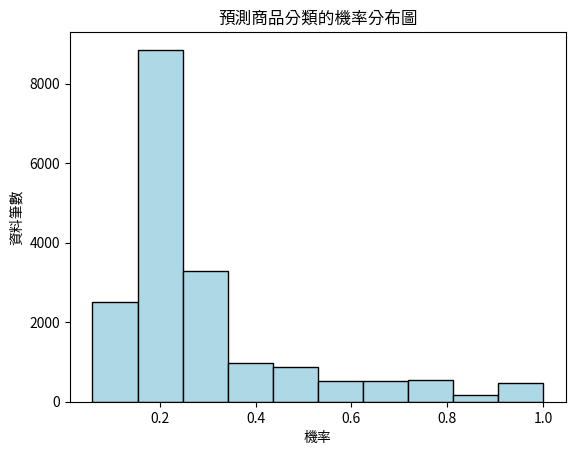

In [ ]:
plt.hist(result_df.prob, color='lightblue', edgecolor='black')
plt.xlabel('機率')
plt.ylabel('資料筆數')
plt.title('預測商品分類的機率分布圖')

print('probability 超過 50% 的僅有 ',len(result_df.loc[result_df.prob>0.5,]),' 筆 (',round((len(result_df.loc[result_df.prob>0.5,])/len(result_df))*100,2),'%)',sep='')
print('probability 超過 40% 的僅有 ',len(result_df.loc[result_df.prob>0.4,]),' 筆 (',round((len(result_df.loc[result_df.prob>0.4,])/len(result_df))*100,2),'%)',sep='')
# 然而prob超過50%的僅有2416筆(12.88%)
# 超過8000多個商品的probability僅有約0.2

In [ ]:
result_df.loc[(result_df['prob'] < 0.5) & (result_df['prob'] > 0.4), :].head(20)
# 觀察probability介於0.4-0.5的資料，發現即使probability不高，但預測的分類結果幾乎正確

,product,pred_class_2,prob,filter_pred_class_2
12,大師兄 0506 A04-(3盒)LJH-韓國竹碳牙刷(10入)*3,其他,0.48,其他
54,秀炮 0703 A01-伊莎貝爾香皂(潔淨、抗菌)*1,沐浴乳、香皂、手工皂,0.45,沐浴乳、香皂、手工皂
90,新三郎 0313 A06- ( 66L ) 透明可視雙開收納箱*1,收納櫃、抽屜櫃,0.47,收納櫃、抽屜櫃
139,第 181 標(1/22)2024/9月JLE FEN蠶絲蛋白洗髮露500ML+N-R-G髮...,洗髮精,0.47,洗髮精
151,公主 0818 G02-LED可折疊充電風扇LY-5580(顏色隨機)*1-刪單不通知,散熱器/座,0.48,散熱器/座
155,舊三郎 0319 A38-(8件組)鈦赫茲項鍊(盒裝顏色隨機)*4+鈦赫茲手鍊(盒裝顏色隨機)*4,項鍊,0.44,項鍊
159,秀炮 0411 A43-Danger 多功能泡沫清潔劑 (650ml)*1,家用清潔劑,0.46,家用清潔劑
164,【商城】TOUS LOVEME 戀我淡香精 4.5ML,香水、香氛,0.42,香水、香氛
176,NIKE 大勾黑棉短褲 BV2721010,短褲,0.45,短褲
190,第 033 標 (8/8)MK皮帶禮盒組,皮帶,0.41,皮帶


In [ ]:
print('probability介於0.2~0.4的商品共有',len(result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2), :]),'筆',sep='')
print('其中被分類為【其他】的就有',len(result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2) & (result_df['pred_class_2']=='其他'), :]),'筆',sep='')

result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2), :].head(20)

# 觀察probability介於0.2~0.4的資料
# 發現約有6成的商品都被分類在「其他」
# 儘管有許多商品名稱裡有明確的名詞，但仍被分類在「其他」 ex.免安裝摺疊多功能「置物架」、柔軟細刷毛「牙刷」
# 但還是有少部分商品儘管probability很低，仍然有被分類正確 ex.垃圾袋、清潔劑、保溫杯

probability介於0.2~0.4的商品共有8472筆
其中被分類為【其他】的就有5216筆


,product,pred_class_2,prob,filter_pred_class_2
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,其他,0.22,UNK
4,888 0110 A64-(3袋)環保垃圾袋400G*3,垃圾袋,0.21,UNK
7,畢哥 0323 B02-美國DORCO 柔軟細刷毛牙刷 (12PC/盒)*1,其他,0.36,UNK
8,舊三郎 0330 A04-公主派對 女神膠原蛋白飲(24入/箱)*1,其他,0.22,UNK
15,第 178 標(11/24)無痕壁掛萬用收納盒(顏色隨機)一個39元,掛勾,0.25,UNK
17,888 1109 G12-【DAZZLING HOME】陶瓷不沾鍋具8件組*1-後台看價格,餐具,0.28,UNK
18,叫賣 0829 A17-(2條)【WK】全速Pro數據線 (MICRO) WDC-092M*2,其他,0.24,UNK
21,888 1004 A08-(4罐)PRIL 高效能濃縮洗碗精-蘆薈護手750ml*4,家用清潔劑,0.34,UNK
23,畢哥 0325 K16-和秋麻辣 (豆腐)*1,貓砂&貓砂盆,0.22,UNK
24,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,其他,0.22,UNK


In [ ]:
result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2) & (result_df['pred_class_2']!='其他'), :].head(20)

# 篩選probability介於0.2~0.4的資料，並先將分類在「其他」的商品排除，觀察其餘商品分類狀況
# 從下面可以發現有少部分分類結果不太理想，ex.小類為「貓砂&貓砂盆」的商品皆跟貓咪完全無關

,product,pred_class_2,prob,filter_pred_class_2
4,888 0110 A64-(3袋)環保垃圾袋400G*3,垃圾袋,0.21,UNK
15,第 178 標(11/24)無痕壁掛萬用收納盒(顏色隨機)一個39元,掛勾,0.25,UNK
17,888 1109 G12-【DAZZLING HOME】陶瓷不沾鍋具8件組*1-後台看價格,餐具,0.28,UNK
21,888 1004 A08-(4罐)PRIL 高效能濃縮洗碗精-蘆薈護手750ml*4,家用清潔劑,0.34,UNK
23,畢哥 0325 K16-和秋麻辣 (豆腐)*1,貓砂&貓砂盆,0.22,UNK
26,舊三郎 0331 A02-(10件組)和秋麻辣 (豆腐)*5+和秋麻辣鴨血*5,貓砂&貓砂盆,0.22,UNK
31,公主 0614 A08-(限+2)防護外套*2(80kg內/男女都可穿)\t\t\t\t\t...,運動外套/戶外機能外套,0.29,UNK
34,第 010 標 (3/4)316不鏽鋼保溫杯,保溫杯、保溫瓶,0.23,UNK
40,公主 0501 A20-(2瓶)【Bioneo 德國百妮】粉鑽潤色CC霜SPF50 (50m...,炒鍋、平底鍋,0.21,UNK
41,(0217活動)COVERNAT大C經典LOGO款CR01-藍 M號,大學T,0.25,UNK


In [ ]:
result_df.loc[(result_df['prob'] < 0.4) & (result_df['prob'] > 0.2) & (result_df['pred_class_2']=='貓砂&貓砂盆'), :].head()
# 被分類為「貓砂&貓砂盆」的商品共有84筆，且都是食物（麻辣豆腐、麻辣鴨血）

,product,pred_class_2,prob,filter_pred_class_2
23,畢哥 0325 K16-和秋麻辣 (豆腐)*1,貓砂&貓砂盆,0.22,UNK
26,舊三郎 0331 A02-(10件組)和秋麻辣 (豆腐)*5+和秋麻辣鴨血*5,貓砂&貓砂盆,0.22,UNK
581,舊三郎 0412 C14-(10包/各半)HC-和秋麻辣 (豆腐)*5+HC-和秋麻辣鴨血*5,貓砂&貓砂盆,0.22,UNK
584,公主 0120 A29-和秋麻辣 (豆腐)*1,貓砂&貓砂盆,0.22,UNK
644,畢哥 0814 A08-和秋麻辣 (豆腐)*1,貓砂&貓砂盆,0.22,UNK


In [ ]:
df.loc[df['小類']=='貓砂&貓砂盆', :]
# 回去觀察shopee training dataset，發現可能因為有叫做"豆腐砂"的貓砂，導致食物的"豆腐"以及跟豆腐相似的"鴨血"被分類在「貓砂&貓砂盆」

,商品名稱,大類,小類
7965,日本黑白貓咪圓盤20cm,寵物,貓砂&貓砂盆
10527,IRIS抗菌芳香尿布墊 (88入),寵物,貓砂&貓砂盆
21399,網購宅配運費-外島 順發蝦皮賣場,寵物,貓砂&貓砂盆
21650,CAT.6e超六類水晶頭(20入)-,寵物,貓砂&貓砂盆
36160,MAYITWILL 米尾 負離子凈味器 貓砂盆 除臭 貓廁所 淨化氣味 充電式 無耗材,寵物,貓砂&貓砂盆
...,...,...,...
249105,小喵同學兩包優惠組【現貨】,寵物,貓砂&貓砂盆
249109,Pine Litter松木砂 8lbs-史上最強吸水性,寵物,貓砂&貓砂盆
249118,樂透典雅貓砂盆-紅/綠,寵物,貓砂&貓砂盆
249143,汪喵星球-益生菌消臭豆腐砂（礦型）6L,寵物,貓砂&貓砂盆


In [ ]:
# prob低於20%的，看起來預測皆有問題，很可能是這些詞很少出現在我們訓練的語料庫當中
# 第一則很有可能是看到「抗菌」就直覺想到洗手乳
result_df.loc[result_df.prob<0.2,].head(10)

,product,pred_class_2,prob,filter_pred_class_2
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,洗手乳,0.12,UNK
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,其他,0.16,UNK
5,畢哥 0523 B21-(4件組)Cab's SHOWERHEAD 黑金一鍵止水萬向蓮蓬頭*...,餐具,0.12,UNK
6,第 087 標(9/25)304不銹鋼蓮花蒸架(底部有點利.可以接受再下單)一個50元,經典文學及古典小說,0.15,UNK
9,🅿西班牙純種伊比利梅花豬*1公斤(肉片/兩盒),其他,0.16,UNK
10,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,其他,0.18,UNK
11,公主 0911 A10-FU TOGO森沐不鏽鋼真空辦公杯*1-咖,快煮壺,0.14,UNK
13,(闆)888 1003 A14-(5盒)cab's 芽孢多益菌*5-節單缺貨刪單不通知,漫畫,0.13,UNK
14,888 1101 A24-QUILT SERIES親膚發熱被(180*210CM)(顏色隨機...,其他,0.15,UNK
19,舊三郎 1110 A18-(限+2)(5盒)cab's 雙酵奇蹟 (15包/盒)*5,漫畫,0.19,UNK


# 彙整大類與小類預測結果

In [20]:
# 原始資料
import pandas as pd
jambo2 = pd.read_csv("jambo_2.csv")
jambo2

,channel_name,商品id,商品名稱
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3
...,...,...,...
18747,邦成-自倉（C倉出貨付款全開）,7104450,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...
18748,邦成-自倉（C倉出貨付款全開）,2935216,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...
18749,邦成-自倉（C倉出貨付款全開）,3139688,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8
18750,邦成-自倉（C倉出貨付款全開）,6235450,888 0208 A23-(3罐)Day365香沁身體乳350ml*3


In [21]:
# 預測資料
result_df1 = pd.read_csv("Label_result_df.csv")
result_df2 = pd.read_csv("subLabel_result_df.csv")

result_df1

,product,pred_class_1,prob,filter_pred_class_1
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,0.803048,家用電器
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,居家生活,0.581099,居家生活
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,居家生活,0.544095,居家生活
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,居家生活,0.931380,居家生活
4,888 0110 A64-(3袋)環保垃圾袋400G*3,居家生活,0.823938,居家生活
...,...,...,...,...
18747,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,保健,0.776251,保健
18748,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,美妝保養,0.974126,美妝保養
18749,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,美食、伴手禮,0.555155,美食、伴手禮
18750,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,美妝保養,0.895431,美妝保養


In [22]:
result_df2

,product,pred_class_2,prob,filter_pred_class_2
0,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,洗手乳,0.12,UNK
1,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,其他,0.16,UNK
2,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,其他,0.22,UNK
3,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,家用清潔劑,0.54,家用清潔劑
4,888 0110 A64-(3袋)環保垃圾袋400G*3,垃圾袋,0.21,UNK
...,...,...,...,...
18747,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,養顏美容食品,0.12,UNK
18748,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,沐浴乳、香皂、手工皂,0.41,沐浴乳、香皂、手工皂
18749,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,其他,0.20,UNK
18750,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,漫畫,0.24,UNK


In [23]:
sum((jambo2['商品名稱'] != result_df1['product']) & (result_df1['product'] != result_df2['product'])) # 確定資料欄位排序相同

0

In [24]:
jambo2['大類'] = result_df1['pred_class_1']
jambo2['小類'] = result_df2['pred_class_2']
jambo2['大類預測機率'] = result_df1['prob']
jambo2['小類預測機率'] = result_df2['prob']
jambo2

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,洗手乳,0.803048,0.12
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,居家生活,其他,0.581099,0.16
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,居家生活,其他,0.544095,0.22
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,居家生活,家用清潔劑,0.931380,0.54
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3,居家生活,垃圾袋,0.823938,0.21
...,...,...,...,...,...,...,...
18747,邦成-自倉（C倉出貨付款全開）,7104450,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,保健,養顏美容食品,0.776251,0.12
18748,邦成-自倉（C倉出貨付款全開）,2935216,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,美妝保養,沐浴乳、香皂、手工皂,0.974126,0.41
18749,邦成-自倉（C倉出貨付款全開）,3139688,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,美食、伴手禮,其他,0.555155,0.20
18750,邦成-自倉（C倉出貨付款全開）,6235450,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,美妝保養,漫畫,0.895431,0.24


In [26]:
# 檢查大類與小類是否存在階層關係
df_sample = pd.read_csv('df_sample.csv')
class_12 = df_sample['大類-小類'].drop_duplicates().tolist()
jambo2['存在階層關係'] = np.where((jambo2['大類']+'-'+jambo2['小類']).isin(class_12), 1, 0) # 1: 存在, 0: 不存在
jambo2[jambo2['存在階層關係']==0] # 預測結果不存在階層關係的有4200筆

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,洗手乳,0.803048,0.12,0
5,邦成-自倉（C倉出貨付款全開）,3395792,畢哥 0523 B21-(4件組)Cab's SHOWERHEAD 黑金一鍵止水萬向蓮蓬頭*...,汽車類,餐具,0.514678,0.12,0
6,TR Box寶藏屋：傘的專家、居的職人,4745320,第 087 標(9/25)304不銹鋼蓮花蒸架(底部有點利.可以接受再下單)一個50元,居家生活,經典文學及古典小說,0.741029,0.15,0
11,邦成-自倉（C倉出貨付款全開）,4595999,公主 0911 A10-FU TOGO森沐不鏽鋼真空辦公杯*1-咖,居家生活,快煮壺,0.585558,0.14,0
13,邦成-自倉（C倉出貨付款全開）,4828679,(闆)888 1003 A14-(5盒)cab's 芽孢多益菌*5-節單缺貨刪單不通知,美食、伴手禮,漫畫,0.574912,0.13,0
...,...,...,...,...,...,...,...,...
18722,邦成-自倉（C倉出貨付款全開）,4837408,叫賣 1004 A09-(2件組)歌林 雙旋鈕8L電烤箱(PA-BO800)*1+BEE T...,家用電器,洗澡玩具,0.614677,0.20,0
18725,邦成-自倉（C倉出貨付款全開）,3093210,大蘋 0419 A01-(1個)Smart Watch 智能手錶(顏色隨機)*1(+3顏色各...,手錶,戒指,0.581023,0.11,0
18727,邦成-自倉（C倉出貨付款全開）,5970165,公主 0112 A23-(3盒)嘗氏薑薑好的鴨-紹興薑母鴨*3,美食、伴手禮,漫畫,0.852536,0.18,0
18750,邦成-自倉（C倉出貨付款全開）,6235450,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,美妝保養,漫畫,0.895431,0.24,0


In [49]:
jambo2['存在階層關係'].mean() # 77%的預測結果存在階層關係

0.7760238907849829

In [31]:
jambo2.to_csv('jambo2_label_temp.csv', index=False)

In [35]:
print(jambo2[(jambo2['大類預測機率']<0.4) & (jambo2['小類預測機率']<0.4)]['存在階層關係'].mean())
jambo2[(jambo2['大類預測機率']<0.4) & (jambo2['小類預測機率']<0.4)]
# 大類小類機率都<0.4的商品中，有七成是存在階層關係，他們的預測結果「有可能」是正確的

0.7003003003003003


,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
10,TR Box寶藏屋：傘的專家、居的職人,4288636,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,美妝保養,其他,0.225520,0.18,1
24,邦成-自倉（C倉出貨付款全開）,7036853,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,其他,0.219548,0.22,1
28,279-🛒現貨直播車,5120110,【商城】DAN D PAK綜合果乾堅果糖170G,愛好與收藏品,穀類、麥片和燕麥,0.334459,0.18,0
29,邦成-自倉（C倉出貨付款全開）,6235014,888 0208 A20-(3件組)KAFEN芬芳去味噴霧(大)(100ML)*2+KAFE...,美妝保養,其他,0.371332,0.15,1
31,邦成-自倉（C倉出貨付款全開）,3622090,公主 0614 A08-(限+2)防護外套*2(80kg內/男女都可穿)\t\t\t\t\t...,男生衣著,運動外套/戶外機能外套,0.375696,0.29,0
...,...,...,...,...,...,...,...,...
18686,邦成-自倉（C倉出貨付款全開）,4372203,公主 0821 A28-(2袋)日本精油神貼(10片/袋)*2,美妝保養,其他,0.283147,0.23,1
18709,邦成-自倉（C倉出貨付款全開）,4376877,賦哥 0822 A04-(2件)托瑪琳自發熱鋼板磁石護腰(袋裝)(XL)*2,男生包包,護具,0.193783,0.19,0
18710,邦成-自倉（C倉出貨付款全開）,5534484,(闆)公主 1206 A08-JIHTENG手持壓麵槍*1--價格後台看,手機平板與周邊,其他,0.338625,0.19,1
18717,邦成-自倉（C倉出貨付款全開）,2765189,公主 0314 A03-X8 LED可調光護眼檯燈 (充電款)*1,汽車類,車燈,0.327068,0.15,1


In [36]:
jambo2[(jambo2['大類預測機率']<0.4) & (jambo2['小類預測機率']<0.4) & (jambo2['存在階層關係']==1)]
# 結果發現這些存在階層關係的商品，多半是被分類到「其他」類

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
10,TR Box寶藏屋：傘的專家、居的職人,4288636,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,美妝保養,其他,0.225520,0.18,1
24,邦成-自倉（C倉出貨付款全開）,7036853,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,其他,0.219548,0.22,1
29,邦成-自倉（C倉出貨付款全開）,6235014,888 0208 A20-(3件組)KAFEN芬芳去味噴霧(大)(100ML)*2+KAFE...,美妝保養,其他,0.371332,0.15,1
52,邦成-自倉（C倉出貨付款全開）,3127515,888 0423 A07-(14件)公主派對。雙龍鴕鳥精膠囊 (30顆/盒)*13+Fasc...,保健,其他,0.232781,0.19,1
80,邦成-自倉（C倉出貨付款全開）,3597810,大師兄 0612 A02-護目鏡(顏色隨機)*1 限+1---刪單不通知,保健,其他,0.166250,0.19,1
...,...,...,...,...,...,...,...,...
18676,蔥媽媽直播,6787412,第 302 標 (3/23)洋蔥圈,愛好與收藏品,其他,0.307452,0.24,1
18686,邦成-自倉（C倉出貨付款全開）,4372203,公主 0821 A28-(2袋)日本精油神貼(10片/袋)*2,美妝保養,其他,0.283147,0.23,1
18710,邦成-自倉（C倉出貨付款全開）,5534484,(闆)公主 1206 A08-JIHTENG手持壓麵槍*1--價格後台看,手機平板與周邊,其他,0.338625,0.19,1
18717,邦成-自倉（C倉出貨付款全開）,2765189,公主 0314 A03-X8 LED可調光護眼檯燈 (充電款)*1,汽車類,車燈,0.327068,0.15,1


In [37]:
jambo2[(jambo2['大類預測機率']<0.4) & (jambo2['小類預測機率']<0.4) & (jambo2['存在階層關係']==1) & (jambo2['小類']=='其他')]
# 承上，剛剛1166筆資料中，有1047筆的小類是被分到「其他」的，而幾乎每個大類裡面都有「其他」，我們的猜想不完全正確
# 如：洋蔥圈、抓餅就不應該被分類到書籍或是愛好收藏品類

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
10,TR Box寶藏屋：傘的專家、居的職人,4288636,第 014 標(8/14)2022年3月台灣製Camu Camu卡姆卡姆BB美妍Plus 1...,美妝保養,其他,0.225520,0.18,1
24,邦成-自倉（C倉出貨付款全開）,7036853,秀炮 0411 A04-(10盒)升級版 BRE魔塑果膠XS(8包/盒)*10,愛好與收藏品,其他,0.219548,0.22,1
29,邦成-自倉（C倉出貨付款全開）,6235014,888 0208 A20-(3件組)KAFEN芬芳去味噴霧(大)(100ML)*2+KAFE...,美妝保養,其他,0.371332,0.15,1
52,邦成-自倉（C倉出貨付款全開）,3127515,888 0423 A07-(14件)公主派對。雙龍鴕鳥精膠囊 (30顆/盒)*13+Fasc...,保健,其他,0.232781,0.19,1
80,邦成-自倉（C倉出貨付款全開）,3597810,大師兄 0612 A02-護目鏡(顏色隨機)*1 限+1---刪單不通知,保健,其他,0.166250,0.19,1
...,...,...,...,...,...,...,...,...
18663,蔥媽媽直播,4499229,第 0016 標 (9/3)抓餅,書籍及雜誌期刊,其他,0.317939,0.24,1
18676,蔥媽媽直播,6787412,第 302 標 (3/23)洋蔥圈,愛好與收藏品,其他,0.307452,0.24,1
18686,邦成-自倉（C倉出貨付款全開）,4372203,公主 0821 A28-(2袋)日本精油神貼(10片/袋)*2,美妝保養,其他,0.283147,0.23,1
18710,邦成-自倉（C倉出貨付款全開）,5534484,(闆)公主 1206 A08-JIHTENG手持壓麵槍*1--價格後台看,手機平板與周邊,其他,0.338625,0.19,1


In [38]:
jambo2[(jambo2['大類預測機率']<0.4) & (jambo2['小類預測機率']<0.4) & (jambo2['存在階層關係']==0)]
# 就算是不存在階層關係的預測結果，也有部分是大類正確、小類錯誤，或是大類錯誤、小類正確，抑或兩者皆對或皆錯，不好決定 threshold
# 所以決定改用 5th percentile (quantile) 作為判斷標準，小於該值者為[UNK]

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
28,279-🛒現貨直播車,5120110,【商城】DAN D PAK綜合果乾堅果糖170G,愛好與收藏品,穀類、麥片和燕麥,0.334459,0.18,0
31,邦成-自倉（C倉出貨付款全開）,3622090,公主 0614 A08-(限+2)防護外套*2(80kg內/男女都可穿)\t\t\t\t\t...,男生衣著,運動外套/戶外機能外套,0.375696,0.29,0
44,邦成-自倉（C倉出貨付款全開）,4188132,畢哥 0806 A31-(4個)無痕掛勾(6個/卡)*4,愛好與收藏品,掛勾,0.183126,0.28,0
70,邦成-自倉（C倉出貨付款全開）,3507218,公主 0603 H02-(限+5)手持非接觸測溫槍*1($價格後台看),居家生活,吸塵器/地板保養用具,0.243032,0.16,0
91,阿清服裝,2956169,(活動4/4)KENZO黃虎手拿包,愛好與收藏品,晚宴包/手拿包,0.203974,0.23,0
...,...,...,...,...,...,...,...,...
18453,邦成-自倉（C倉出貨付款全開）,3598768,叫賣 0612 G04-防護外套*1(80kg內/男女都可穿),男生衣著,運動外套/戶外機能外套,0.241037,0.32,0
18486,邦成-自倉（C倉出貨付款全開）,2896343,新三郎 0329 A02-(10包)小白清潔 運動鞋清潔濕巾 (12片)*10,居家生活,濕紙巾,0.291788,0.13,0
18632,TR Box寶藏屋：傘的專家、居的職人,3140164,第 073 標(4/24)日本製二代合金剪刀(包裝顏色款式隨機)一支68元,居家生活,剪刀,0.291750,0.14,0
18675,邦成-自倉（C倉出貨付款全開）,2928951,舊三郎 0401 A31-MOSKILLER 靜享 無蚊之境 滅蚊燈*1,居家生活,經典文學及古典小說,0.269756,0.14,0


In [45]:
# 5th percentile (quantile)
big_threshold = np.percentile(jambo2['大類預測機率'], 5)
small_threshold = np.percentile(jambo2['小類預測機率'], 5)
print(big_threshold, small_threshold)

0.3231513775 0.13


In [46]:
print(sum(jambo2['大類預測機率']<big_threshold), sum(jambo2['小類預測機率']<small_threshold))

938 785


In [47]:
# 條件判斷給定[UNK]，並維持大小類間的階層關係
for i in range(len(jambo2)):
  if (jambo2['存在階層關係'][i]==1) and (jambo2['大類預測機率'][i]>big_threshold) and (jambo2['小類預測機率'][i]>small_threshold):
    next
  elif (jambo2['存在階層關係'][i]==0) and (jambo2['大類預測機率'][i]>big_threshold) and (jambo2['小類預測機率'][i]>small_threshold):
    if jambo2['大類預測機率'][i] > jambo2['小類預測機率'][i]:
      jambo2['小類'][i]='[UNK]'
    else:
      jambo2['大類'][i]='[UNK]'
  elif (jambo2['大類預測機率'][i]>big_threshold) and (jambo2['小類預測機率'][i]<=small_threshold):
    jambo2['小類'][i]='[UNK]'
  elif (jambo2['大類預測機率'][i]<=big_threshold) and (jambo2['小類預測機率'][i]>small_threshold):
    jambo2['大類'][i]='[UNK]'
  else:
    jambo2['大類'][i]='[UNK]'
    jambo2['小類'][i]='[UNK]'

jambo2

<ipython-input-47-acaa1ece9be7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jambo2['小類'][i]='[UNK]'
<ipython-input-47-acaa1ece9be7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jambo2['小類'][i]='[UNK]'
<ipython-input-47-acaa1ece9be7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jambo2['大類'][i]='[UNK]'
<ipython-input-47-acaa1ece9be7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,channel_name,商品id,商品名稱,大類,小類,大類預測機率,小類預測機率,存在階層關係
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,家用電器,[UNK],0.803048,0.12,0
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,居家生活,其他,0.581099,0.16,1
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,居家生活,其他,0.544095,0.22,1
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,居家生活,家用清潔劑,0.931380,0.54,1
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3,居家生活,垃圾袋,0.823938,0.21,1
...,...,...,...,...,...,...,...,...
18747,邦成-自倉（C倉出貨付款全開）,7104450,王三郎 0416 A01-(6罐)【台鹽生技】微滴科技修復彈力濃萃晶露35ml(效期2023...,保健,[UNK],0.776251,0.12,1
18748,邦成-自倉（C倉出貨付款全開）,2935216,888 0402 C01-(6件組)Sebamed 運動二合一洗髮沐浴乳 (200ml)*3...,美妝保養,沐浴乳、香皂、手工皂,0.974126,0.41,1
18749,邦成-自倉（C倉出貨付款全開）,3139688,畢哥 0424 A05-(8罐)Spearmint香香粒 200g (味道隨機)*8,美食、伴手禮,其他,0.555155,0.20,1
18750,邦成-自倉（C倉出貨付款全開）,6235450,888 0208 A23-(3罐)Day365香沁身體乳350ml*3,美妝保養,[UNK],0.895431,0.24,0


In [48]:
jambo2.to_csv('jambo2_label_temp2.csv', index=False)
jambo2[['channel_name','商品id','商品名稱','大類','小類']].to_csv('jambo2_label.csv', index=False)

# 附錄

附錄是我們嘗試的其他方法，一併附上。

## 大類分類：TFIDF + Naive Bayse



- **用結巴斷詞**

```
Accuracy: 0.6850393700787402
precision recall  F1
0.75      0.69      0.66
```

- **用ckip tagger斷詞**

```
Accuracy: 0.6820109024833434
precision recall  F1
0.74      0.68      0.66  
```


使用ckip tagger斷詞看起來效果沒有比較好

In [ ]:
# download the file
!gdown --id '18b9F-_rRJIewiExftVNBDIcZ4hsIidfU' --output shopee.csv
# 執行完後，應該可以看到左邊檔案區有這個文件(shopee.csv)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18b9F-_rRJIewiExftVNBDIcZ4hsIidfU
To: /content/shopee.csv
100% 25.8M/25.8M [00:00<00:00, 240MB/s]


In [ ]:
df = pd.read_csv('shopee.csv')
print(df.shape)
df.drop_duplicates(inplace=True) # 原始資料有重複的觀測值，去除重複值
print(df.shape)
df.head()

# 新增一個欄位，方便建模型使用
df['大類-小類'] = df['大類']+"-"+df['小類']
df.head()

# 分層隨機抽樣(3%)
random.seed(2023) # 設定隨機種子，確保每次執行都是一樣的結果
df_sample = pd.DataFrame()
for class_1 in df['大類'].drop_duplicates():
    df_sub = df[df['大類']==class_1]
    for class_2 in df_sub['小類'].drop_duplicates():
        df_sub2 = df_sub[df_sub['小類']==class_2]
        if df_sub2.shape[0]*0.03 <= 1: # 樣本數太少(<=33)就全抽
            df_sample = pd.concat([df_sample, df_sub2], axis=0)
        else:
            df_sample = pd.concat([df_sample,
                                   df_sub2.iloc[random.sample([x for x in range(df_sub2.shape[0])], k=math.ceil(df_sub2.shape[0]*0.03)),]], axis=0)
print(df_sample.shape)
df_sample.head(3)

(253285, 3)
(253188, 3)
(8255, 4)


,商品名稱,大類,小類,大類-小類
27187,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
143980,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
27640,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊


In [ ]:
df_sample = df_sample.reset_index(drop=True) # reset index才有辦法做後續的資料清理
# 除去數字
label = []
for i in range(len(df_sample)):
    text = df_sample["商品名稱"][i]
    label.append(re.sub(r'[0-9]+', '', text))
df_sample["productName"] = label

# 斷詞
# 結巴
def tokenize(text):
    words = jieba.lcut(text)
    return " ".join(words)

# 將 DataFrame 中的中文文本進行斷詞
#df_sample["商品名稱"] = df_sample["商品名稱"].apply(tokenize)
df_sample["productName_jie"] = df_sample["productName"].apply(tokenize)

df_sample.head(3)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.406 seconds.
DEBUG:jieba:Loading model cost 1.406 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,商品名稱,大類,小類,大類-小類,productName,productName_jie
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH歐新力奇 S 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,OCEANRICH 歐新力 奇 S 木紋 便 攜旋轉 咖啡 機 手 沖 不 ...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD 日本職人級全自動手沖咖啡機 CM-DTW 【全國電子】,TWINBIRD 日本 職人級 全自動手 沖 咖啡 機 CM - DTW 【...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬復古半磅磨豆機 N 現貨 廠商直送,小飛馬 復 古 半磅 磨豆機 N 現貨 廠商直 送


In [ ]:
## jieba
texts = tuple(df_sample["productName_jie"])
labels = tuple(df_sample["大類"])

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# 將文本轉換為 TF-IDF 特徵
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

classifier = MultinomialNB()
classifier.fit(X_train, train_labels)
probabilities = classifier.predict_proba(X_test)
predictions = classifier.predict(X_test)
threshold = np.percentile(probabilities, 10)   # 可以自己調整
predictions = ['UNK' if max(prob) < threshold else classifier.classes_[prob.argmax()] for prob in probabilities]

In [ ]:
df_jambo2.head()

,channel_name,商品id,商品名稱
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3


In [ ]:
# 除去數字
label = []
for i in range(len(df_jambo2)):
    text = df_jambo2["商品名稱"][i]
    label.append(re.sub(r'[0-9]+', '', text))
df_jambo2["productName"] = label

# 斷詞
df_jambo2["productName_jie"] = df_jambo2["productName"].apply(tokenize)

In [ ]:
texts = tuple(df_jambo2["productName_jie"])
jambo_test = vectorizer.transform(texts)

In [ ]:
probabilities = classifier.predict_proba(jambo_test)
predictions = classifier.predict(jambo_test)
threshold = np.percentile(probabilities, 10)   # 可以自己調整
predictions = ['UNK' if max(prob) < threshold else classifier.classes_[prob.argmax()] for prob in probabilities]
df_jambo2['預測大類'] = predictions

In [ ]:
df_jambo2.head(10)

,channel_name,商品id,商品名稱,productName,productName_jie,預測大類
0,邦成-自倉（C倉出貨付款全開）,2787822,舊三郎 0317 A29-dstt 聚寶盆抗菌微壓鍋 7L (DSTTWY24)*1,舊三郎 A-dstt 聚寶盆抗菌微壓鍋 L (DSTTWY)*,舊三郎 A - dstt 聚寶盆 抗菌 微壓鍋 L ( DSTTWY ) *,居家生活
1,邦成-自倉（C倉出貨付款全開）,4545243,公主 0907 A10-HANNAH強效管道疏通粉劑30g (10袋/盒)*1,公主 A-HANNAH強效管道疏通粉劑g (袋/盒)*,公主 A - HANNAH 強效 管道 疏通 粉劑 g ( 袋 / 盒 ) *,母嬰用品
2,邦成-自倉（C倉出貨付款全開）,2868377,大蘋 0325 K27-(-五層-) 免安裝摺疊多功能置物架 (158*34*71)*1,大蘋 K-(-五層-) 免安裝摺疊多功能置物架 (**)*,大蘋 K - ( - 五層 - ) 免安裝 摺 疊 多功能 置物架 ( * ...,居家生活
3,TR Box寶藏屋：傘的專家、居的職人,4249281,第 005 標(8/11)2023年7月洗衣槽清潔錠12錠一盒19元,第 標(/)年月洗衣槽清潔錠錠一盒元,第 標 ( / ) 年 月 洗衣 槽 清潔錠 錠 一盒 元,居家生活
4,邦成-自倉（C倉出貨付款全開）,5944955,888 0110 A64-(3袋)環保垃圾袋400G*3,A-(袋)環保垃圾袋G*,A - ( 袋 ) 環保 垃圾袋 G *,居家生活
5,邦成-自倉（C倉出貨付款全開）,3395792,畢哥 0523 B21-(4件組)Cab's SHOWERHEAD 黑金一鍵止水萬向蓮蓬頭*...,畢哥 B-(件組)Cab's SHOWERHEAD 黑金一鍵止水萬向蓮蓬頭*+（-濾心-）...,畢哥 B - ( 件 組 ) Cab ' s SHOWERHEAD 黑金 一...,母嬰用品
6,TR Box寶藏屋：傘的專家、居的職人,4745320,第 087 標(9/25)304不銹鋼蓮花蒸架(底部有點利.可以接受再下單)一個50元,第 標(/)不銹鋼蓮花蒸架(底部有點利.可以接受再下單)一個元,第 標 ( / ) 不銹 鋼蓮花 蒸架 ( 底部 有點利 . 可以 接受 再 下單 ...,書籍及雜誌期刊
7,邦成-自倉（C倉出貨付款全開）,2844785,畢哥 0323 B02-美國DORCO 柔軟細刷毛牙刷 (12PC/盒)*1,畢哥 B-美國DORCO 柔軟細刷毛牙刷 (PC/盒)*,畢哥 B - 美國 DORCO 柔軟細 刷毛 牙刷 ( PC / 盒 ) *,母嬰用品
8,邦成-自倉（C倉出貨付款全開）,2911818,舊三郎 0330 A04-公主派對 女神膠原蛋白飲(24入/箱)*1,舊三郎 A-公主派對 女神膠原蛋白飲(入/箱)*,舊三郎 A - 公主 派 對 女神 膠原 蛋白 飲 ( 入 / 箱 ) *,母嬰用品
9,拼鮮水產 足度男直播買賣,7194293,🅿西班牙純種伊比利梅花豬*1公斤(肉片/兩盒),🅿西班牙純種伊比利梅花豬*公斤(肉片/兩盒),🅿 西班牙 純種 伊比利 梅花 豬 * 公斤 ( 肉片 / 兩盒 ),居家生活


In [ ]:
df_jambo2.to_csv("tfidf_category_prediction.csv", index=False, encoding="utf-8")

In [ ]:
# 查看測試集的預測
print(predictions[:5]) # 印前五個預測結果出來
print(test_labels[:5]) # 正確答案
print(test_texts[:5]) # 看起來前三筆都正確，第四筆分錯，第五筆我自己也不知道是什麼

['男生衣著', '美妝保養', '女鞋', '女生衣著', '母嬰用品']
['男生衣著', '美妝保養', '女鞋', '嬰幼兒童裝童鞋', '時尚配件']
['Lee   涼感 藝術 字體 短袖 T恤   男   黑   Urban   Riders   玉石 科技   K', 'Neogence 霓淨思 玻 尿酸 保濕潤澤霜 ml', 'amai   韓系 簡約 方頭後拉 鍊 皮革 襪靴   短靴   粗 跟   深棕   GBCF', '【 出 清 】 QUEENSHOP _   F     童裝   親子 系列 翻蓋 口袋 造型 燈心絨 襯衫     S - L       現 + 預 【 】', '【 小熊 維尼 】   -   維尼 夾式 組合 / 跳跳虎 款']


In [ ]:
## ckip tagger
texts = tuple(df_sample["productName_ckip"])
labels = tuple(df_sample["大類"])
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)
probabilities = classifier.predict_proba(X_test)
predictions = classifier.predict(X_test)
threshold = np.percentile(probabilities, 10)
predictions = ['UNK' if max(prob) < threshold else classifier.classes_[prob.argmax()] for prob in probabilities]

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(test_labels, predictions))

Accuracy: 0.6820109024833434

Classification Report:
              precision    recall  f1-score   support

          保健       0.78      0.23      0.35        31
     女生包包/精品       0.91      0.56      0.69        54
        女生衣著       0.54      0.97      0.69       136
          女鞋       0.81      0.45      0.58        47
     嬰幼兒童裝童鞋       0.88      0.26      0.41        53
        家用電器       0.84      0.44      0.58        48
          寵物       0.98      0.81      0.89        68
        居家生活       0.47      0.84      0.61       141
          影音       0.00      0.00      0.00         7
      愛好與收藏品       0.82      0.76      0.79       119
     戶外與運動用品       0.69      0.56      0.62        64
     手機平板與周邊       0.96      0.59      0.73        41
          手錶       1.00      0.60      0.75        25
     文具、美術用具       0.00      0.00      0.00        30
  旅行相關用品/行李箱       0.00      0.00      0.00         9
        時尚配件       0.93      0.79      0.85        80
     書籍及雜誌期刊       0.73     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(predictions[:5]) #第一個就判斷錯
print(test_labels[:5])
print(test_texts[:5])

['女生衣著', '美妝保養', '女鞋', '女生衣著', '母嬰用品']
['男生衣著', '美妝保養', '女鞋', '嬰幼兒童裝童鞋', '時尚配件']
['Lee  涼感 藝術 字體 短袖 T恤   男   黑  Urban  Riders  玉石 科技  210148 K 11', 'Neogence 霓淨思玻 尿酸 保濕 潤澤霜 50 ml', 'amai  韓系 簡約 方頭 後 拉鍊 皮革 襪靴   短靴   粗 跟   深棕  GB 604 CF', '【 出清 】 QUEENSHOP_ F   童裝   親子 系列 翻蓋 口袋 造型 燈心絨 襯衫   S-L    現 + 預 【 01024411 】', '【 小 熊 維尼 】  -  維尼夾式 組合 / 跳跳 虎款']


## 大類分類：TextCNN

Training Accuracy = 0.99

Testing Accuracy = 0.66

In [ ]:
df_sample = pd.read_csv('/content/drive/MyDrive/df_sample_1.csv')
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
train,test = train_test_split(df_sample[['商品名稱_clean','大類']])

print('train.shape=',train.shape)
print('test.shape=',test.shape)

train.shape= (6193, 2)
test.shape= (2065, 2)


In [ ]:
pip install -U torchtext==0.6.0

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext.data  import Field, TabularDataset, BucketIterator, Iterator
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

TEXT = Field(lower=True, include_lengths=True,fix_length=1000, batch_first=True)
LABEL = Field(sequential=False)
fields = {'商品名稱_clean': ('text',TEXT),'大類': ('label',LABEL)}

train, test = TabularDataset.splits(path='/content/',
                                    train='train.csv',
                                    test='test.csv',
                                    format='csv',
                                    fields=fields)

In [ ]:
train

In [ ]:


TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, test_iter = BucketIterator.splits((train, test), batch_size=32, device=0,sort=False)

In [ ]:
train_iter

In [ ]:
class TextCNN(nn.Module):

    def __init__(self, embed_dim = 128, kernel_size=[2,3,4]):
        super(TextCNN,self).__init__()
        self.kernel_size = kernel_size

        self.embed = nn.Embedding(len(TEXT.vocab),embed_dim)
        self.cnn = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1,32,(kernel,embed_dim)),
                nn.LeakyReLU()
            )
            for kernel in kernel_size
        ])
        self.fc = nn.Linear(32*len(kernel_size),len(LABEL.vocab))

    def forward(self,x):
        tmp = self.embed(x).unsqueeze(1) # Batch_size, channel_number, Seq_len, embed_dim
        tmp = [c(tmp).squeeze(3) for c in self.cnn] # Batch_size, filter_number, Width
        tmp = [F.max_pool1d(t,t.size(2)).squeeze(2) for t in tmp] # Batch_size, filter_number
        tmp = torch.cat(tmp,1)
        tmp = self.fc(tmp)

        return tmp

In [ ]:
model = TextCNN().cuda()

RuntimeError: ignored

In [ ]:
## 測試 forward
for i in train_iter:
    text = i.text[0].cuda()
    output = model(text)
    print(output.shape)
    break

torch.Size([32, 28])


In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [ ]:
epoches = 20
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = data.label.cuda()-1

        output = model(text)

        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward(retain_graph=True)
        optim.step()

        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

100%|██████████| 194/194 [00:05<00:00, 32.34it/s]


epoch 1 : 0.08854399138576434


100%|██████████| 194/194 [00:05<00:00, 33.08it/s]


epoch 2 : 0.06902083435486692


100%|██████████| 194/194 [00:05<00:00, 33.84it/s]


epoch 3 : 0.05325574153424002


100%|██████████| 194/194 [00:05<00:00, 37.13it/s]


epoch 4 : 0.040059716293812955


100%|██████████| 194/194 [00:05<00:00, 33.99it/s]


epoch 5 : 0.02940690374982659


100%|██████████| 194/194 [00:05<00:00, 32.55it/s]


epoch 6 : 0.021803068518927347


100%|██████████| 194/194 [00:05<00:00, 37.12it/s]


epoch 7 : 0.01646660003632466


100%|██████████| 194/194 [00:05<00:00, 34.53it/s]


epoch 8 : 0.012738148354134652


100%|██████████| 194/194 [00:05<00:00, 32.59it/s]


epoch 9 : 0.009737782294600456


100%|██████████| 194/194 [00:05<00:00, 37.08it/s]


epoch 10 : 0.007536617031144379


100%|██████████| 194/194 [00:05<00:00, 35.53it/s]


epoch 11 : 0.0056953913846949315


100%|██████████| 194/194 [00:06<00:00, 31.80it/s]


epoch 12 : 0.0041945088509185696


100%|██████████| 194/194 [00:05<00:00, 36.93it/s]


epoch 13 : 0.003042873642387056


100%|██████████| 194/194 [00:06<00:00, 31.46it/s]


epoch 14 : 0.0021522673669960076


100%|██████████| 194/194 [00:06<00:00, 31.30it/s]


epoch 15 : 0.0015084092082248526


100%|██████████| 194/194 [00:05<00:00, 37.04it/s]


epoch 16 : 0.001053195919158187


100%|██████████| 194/194 [00:05<00:00, 35.45it/s]


epoch 17 : 0.0007225629761087217


100%|██████████| 194/194 [00:06<00:00, 31.63it/s]


epoch 18 : 0.0005237994606994801


100%|██████████| 194/194 [00:05<00:00, 36.41it/s]


epoch 19 : 0.0003870040004305697


100%|██████████| 194/194 [00:05<00:00, 36.79it/s]

epoch 20 : 0.00028904501567390936


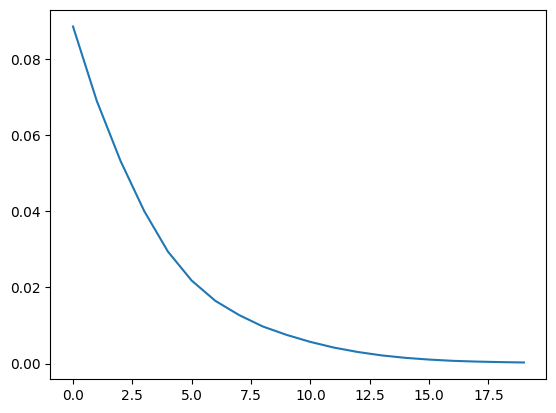

In [ ]:
plt.plot(training_loss)

In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(train))

100%|██████████| 194/194 [00:01<00:00, 101.04it/s]

Accuracy= 1.0


In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(test_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(test))

100%|██████████| 65/65 [00:00<00:00, 94.98it/s]

Accuracy= 0.4460048426150121


## 小類分類：CKIP Bert 1

只訓練部分500類，使用原始商品名稱。

In [ ]:
df_sample = pd.read_csv("df_sample_1.csv")
print(df_sample.shape)
df_sample.head()

(8255, 5)


,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
df_sample['product_cut_2'] = df_sample['product_cut'].apply(lambda y: " ".join(re.sub(r'#\w+\s*', "", x) for x in y.split()))
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_2
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,OCEANRICH 歐新力奇 S2 木紋 便攜 旋轉 咖啡機 手 沖 不 插電 露營 廠商 直送
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,TWINBIRD 日本 職人級 全自動 手沖 咖啡機 CM-D457 TW 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 復古 半 磨豆機 600 現貨 廠商 直 送
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,HERAN 禾聯 人 份 自動式 研磨 咖啡機 HCM-09C8 S
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,SYNCO 新格 LED W 輕巧 時尚 檯燈 SLD-045 L 現貨 廠商 直送


In [ ]:
top500 = df_sample['小類'].value_counts()[:500].index
top500

Index(['其他', 'T恤', '公仔', '休閒鞋款', '積木玩具', '牛仔褲', '組裝模型', '側/肩背包', '襪子', '動漫周邊',
       ...
       '臉部清潔工具', '充電座/ 充電盤', '陰道乳膏', '卸甲工具', '鳥類玩具', '衛生棉條', 'BB霜、CC霜', '雙眼皮貼',
       '石膏、繃帶', '電動刮鬍刀'],
      dtype='object', length=500)

In [ ]:
df_sample_2 = df_sample[df_sample['小類'].isin(top500)]
df_sample_2

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_2
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,OCEANRICH 歐新力奇 S2 木紋 便攜 旋轉 咖啡機 手 沖 不 插電 露營 廠商 直送
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,TWINBIRD 日本 職人級 全自動 手沖 咖啡機 CM-D457 TW 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 復古 半 磨豆機 600 現貨 廠商 直 送
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,HERAN 禾聯 人 份 自動式 研磨 咖啡機 HCM-09C8 S
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,SYNCO 新格 LED W 輕巧 時尚 檯燈 SLD-045 L 現貨 廠商 直送
...,...,...,...,...,...,...
8250,【Daniel Wellington】Petite 32mm玫瑰金米蘭錶 X 經典簡約玫瑰金...,手錶,手錶錶帶,手錶-手錶錶帶,Daniel#FW Wellington#FW Petite#FW 32#FW mm#FW ...,Daniel Wellington Petite 32 mm 玫瑰金 米蘭錶 X 經典 簡約...
8251,KENNETH COLE 紐約設計精品錶 KC50917006 鏤空機械錶 自動上鍊 真皮錶...,手錶,手錶錶帶,手錶-手錶錶帶,KENNETHCOLE#FW 紐約#Nc 設計#VC 精品錶#Na KC50917006#F...,KENNETHCOLE 紐約 設計 精品錶 KC50917006 鏤空 機械錶 自動 上鍊 ...
8252,【Daniel Wellington】Quadro Coral 10mm粉珊瑚織紋錶帶 DW錶帶,手錶,手錶錶帶,手錶-手錶錶帶,Daniel#FW Welling#FW ton#FW Quadro#FW Coral#FW...,Daniel Welling ton Quadro Coral 10 mm 粉珊瑚 織紋 錶...
8253,【SWATCH】New Gent 原創系列手錶BLACK BLUR 迷濛黑(41mm) SU...,手錶,手錶錶帶,手錶-手錶錶帶,SWATCH#FW New#FW Gent#FW 原創#VH 系列#Na 手錶#Na BLA...,SWATCH New Gent 原創 系列 手錶 BLACKBLUR 迷濛 黑 mm SUO...


In [ ]:
# data
product = df_sample_2['商品名稱'].to_numpy()
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample_2['小類'].to_numpy())
# label_encoder.inverse_transform(class_1) # 可以轉換回來

# split the data
X_train, X_test, y_train, y_test = train_test_split(product, class_1, test_size=0.2, random_state=42)

In [ ]:
# 確保訓練資料每個類都有
print(df_sample_2['小類'].nunique(),
      len(np.unique(y_train)),
      len(np.unique(y_test)))

500 500 408


In [ ]:
# load pre-trained BERT model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForSequenceClassification.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(np.unique(y_train)))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(torch.cuda.device_count(),"\n",
      torch.cuda.get_device_name(0))

1 
 Tesla T4


In [ ]:
# BERT input conversion
# 將文本數據轉換為適用於BERT模型的輸入格式，以便進行訓練和推理
device = torch.device('cuda')
model.to(device)

def tokenize_reviews(reviews, labels):
    input_ids = []
    attention_masks = []

    for review in reviews:
        encoded_dict = tokenizer.encode_plus( # 使用`tokenizer.encode_plus`函數將文本轉換為BERT可接受的編碼格式
            review, # 當前要處理的文本
            add_special_tokens=True, # 告訴分詞器添加BERT模型所需的特殊tokens，如[CLS]和[SEP]
            max_length=128,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt' # 返回PyTorch張量作為結果
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels
    # 函數返回的值可以直接用於BERT模型進行文本分類或其他NLP任務的輸入

In [ ]:
# BERT fine-tuning

# convert data to PyTorch tensors
input_ids, attention_masks, labels = tokenize_reviews(X_train, y_train)

# create DataLoader for training data
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(dataset, batch_size=15, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [ ]:
# 訓練模型
for epoch in range(epochs): # 模型訓練將在多個時期中進行
  model.train() # 將模型切換到訓練模式。在訓練模式下，模型會計算梯度，並在反向傳播時更新模型參數
  for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
# 5m

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [ ]:
# evaluation
model.eval() # set to evaluation mode
test_input_ids, test_attention_masks, test_labels = tokenize_reviews(X_test, y_test) # 將文本數據轉換為適用於BERT模型的輸入格式
test_input_ids, test_attention_masks, test_labels = test_input_ids.to(device), test_attention_masks.to(device),test_labels.to(device)

with torch.no_grad():
  logits = model(test_input_ids, attention_mask=test_attention_masks)
  probabilities = softmax(logits.logits, dim=1)  # 使用softmax取得概率分布
  max_probabilities = np.max(probabilities.cpu().numpy(), axis=1)
  # threshold = 0.5
  # predicted_labels = np.where(max_probabilities >= threshold, np.argmax(logits.logits.cpu().numpy(), axis=1), '[UNK]')
predicted_labels = np.argmax(logits.logits.cpu().numpy(), axis=1)

In [ ]:
print(predicted_labels)
print(label_encoder.inverse_transform(predicted_labels))
print(len(set(predicted_labels)))

[267 193 388 ... 293  10 278]
['濕紙巾' '時尚靴' '襪子' ... '男錶' '主機板' '牛仔褲']
101


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.4177
precision,0.2911
recall,0.4177
f1_score,0.3080


In [ ]:
# 輸出模型的參數數量
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]

model_params =get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102652148
線性分類器的參數量：384500



In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UNK
threshold = 0.4
result_df = pd.DataFrame({'product': X_test,
                          'class_1': label_encoder.inverse_transform(y_test),
                          'pred_class_1': label_encoder.inverse_transform(predicted_labels),
                          'max_prob': max_probabilities})
result_df['filter_pred_class_1'] = result_df.apply(lambda row: row['pred_class_1'] if row['max_prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
0,3M 百利 家用除菌清潔濕巾桶裝-85入 除菌濕巾,海綿、菜瓜布,濕紙巾,0.026405,UNK
1,PALLADIUM PAMPA LITE OVB NEON輕量標籤軍靴-中性-黑,時尚靴,時尚靴,0.060723,UNK
2,【FAV】機能兒童運動襪/除臭襪/長襪/防滑,襪子,襪子,0.768765,襪子
3,SANLUX台灣三洋170公升超低溫-60℃上掀冷凍櫃 TFS-170G(聊聊享折扣),冷凍櫃,冰箱,0.050575,UNK
4,【BANDA】HiRM 1/100 新機動戰記鋼彈W 無盡的華爾滋 XXXG-00W0 飛翼...,組裝模型,公仔,0.373391,UNK
...,...,...,...,...,...
1580,PUMA 限時特惠 女款休閒鞋 2款可選,休閒鞋款,休閒鞋款,0.524320,休閒鞋款
1581,ZOTAC 索泰 GAMING RTX 3080 AMP Holo LHR 12GB 顯示卡...,顯示卡,筆記型電腦,0.030365,UNK
1582,【CASIO】卡西歐 BABY-G 復古風撞色數位橡膠腕錶/桃紫x白 BGD-560THB-...,女錶,男錶,0.501459,男錶
1583,ASUS華碩 PRIME A520M-K/CSM M-ATX/AM4腳位/主機板/原價屋,主機板,主機板,0.046377,UNK


In [ ]:
result_df[result_df['class_1'] != result_df['pred_class_1']] # 第一個是預測的才正確

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
0,3M 百利 家用除菌清潔濕巾桶裝-85入 除菌濕巾,海綿、菜瓜布,濕紙巾,0.026405,UNK
3,SANLUX台灣三洋170公升超低溫-60℃上掀冷凍櫃 TFS-170G(聊聊享折扣),冷凍櫃,冰箱,0.050575,UNK
4,【BANDA】HiRM 1/100 新機動戰記鋼彈W 無盡的華爾滋 XXXG-00W0 飛翼...,組裝模型,公仔,0.373391,UNK
5,AQ 攜帶式方便嘔吐便利袋 -Autobacs Quality,車用收納,其他,0.116566,UNK
6,New Balance 男女 白藍 透氣 復古 運動 老爹鞋 休閒鞋 ML408B,其他運動鞋,休閒鞋款,0.529635,休閒鞋款
...,...,...,...,...,...
1574,Birkenstock EVA系列 Madrid 藍色 防水 單條拖鞋 128173/128171,其他,休閒鞋款,0.103762,UNK
1575,凱堡 高機能人體工學護脊雙背電腦椅/辦公椅【A42926】現貨 耐重款 台灣製 一年保固,椅子,其他,0.013360,UNK
1581,ZOTAC 索泰 GAMING RTX 3080 AMP Holo LHR 12GB 顯示卡...,顯示卡,筆記型電腦,0.030365,UNK
1582,【CASIO】卡西歐 BABY-G 復古風撞色數位橡膠腕錶/桃紫x白 BGD-560THB-...,女錶,男錶,0.501459,男錶


In [ ]:
# 總共篩選出1182個UNK，其中，923個被預測錯誤的標籤中，有808個成功預測為UNK
print(sum(result_df['filter_pred_class_1']=='UNK'),
      '\n',
      sum(result_df[result_df['class_1'] != result_df['pred_class_1']]['filter_pred_class_1']=='UNK'))

1182 
 808


In [ ]:
# 將accuracy這些整理成dataframe（加入UNK後）
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_1'], result_df['filter_pred_class_1']),
                                    precision_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    recall_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    f1_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # precision會提高

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.1817
precision,0.2247
recall,0.1817
f1_score,0.1847


## 小類分類：CKIP Bert 2

只訓練部分500類，使用斷過詞與篩選詞性商品名稱。

In [ ]:
df_sample = pd.read_csv("df_sample_1.csv")
print(df_sample.shape)
df_sample.head()

(8255, 5)


,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
df_sample['product_cut_2'] = df_sample['product_cut'].apply(lambda y: " ".join(re.sub(r'#\w+\s*', "", x) for x in y.split()))
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_2
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,OCEANRICH 歐新力奇 S2 木紋 便攜 旋轉 咖啡機 手 沖 不 插電 露營 廠商 直送
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,TWINBIRD 日本 職人級 全自動 手沖 咖啡機 CM-D457 TW 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 復古 半 磨豆機 600 現貨 廠商 直 送
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,HERAN 禾聯 人 份 自動式 研磨 咖啡機 HCM-09C8 S
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,SYNCO 新格 LED W 輕巧 時尚 檯燈 SLD-045 L 現貨 廠商 直送


In [ ]:
top500 = df_sample['小類'].value_counts()[:500].index
top500

Index(['其他', 'T恤', '公仔', '休閒鞋款', '積木玩具', '牛仔褲', '組裝模型', '側/肩背包', '襪子', '動漫周邊',
       ...
       '臉部清潔工具', '充電座/ 充電盤', '陰道乳膏', '卸甲工具', '鳥類玩具', '衛生棉條', 'BB霜、CC霜', '雙眼皮貼',
       '石膏、繃帶', '電動刮鬍刀'],
      dtype='object', length=500)

In [ ]:
df_sample_2 = df_sample[df_sample['小類'].isin(top500)]
df_sample_2

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_2
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,OCEANRICH 歐新力奇 S2 木紋 便攜 旋轉 咖啡機 手 沖 不 插電 露營 廠商 直送
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,TWINBIRD 日本 職人級 全自動 手沖 咖啡機 CM-D457 TW 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 復古 半 磨豆機 600 現貨 廠商 直 送
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,HERAN 禾聯 人 份 自動式 研磨 咖啡機 HCM-09C8 S
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,SYNCO 新格 LED W 輕巧 時尚 檯燈 SLD-045 L 現貨 廠商 直送
...,...,...,...,...,...,...
8250,【Daniel Wellington】Petite 32mm玫瑰金米蘭錶 X 經典簡約玫瑰金...,手錶,手錶錶帶,手錶-手錶錶帶,Daniel#FW Wellington#FW Petite#FW 32#FW mm#FW ...,Daniel Wellington Petite 32 mm 玫瑰金 米蘭錶 X 經典 簡約...
8251,KENNETH COLE 紐約設計精品錶 KC50917006 鏤空機械錶 自動上鍊 真皮錶...,手錶,手錶錶帶,手錶-手錶錶帶,KENNETHCOLE#FW 紐約#Nc 設計#VC 精品錶#Na KC50917006#F...,KENNETHCOLE 紐約 設計 精品錶 KC50917006 鏤空 機械錶 自動 上鍊 ...
8252,【Daniel Wellington】Quadro Coral 10mm粉珊瑚織紋錶帶 DW錶帶,手錶,手錶錶帶,手錶-手錶錶帶,Daniel#FW Welling#FW ton#FW Quadro#FW Coral#FW...,Daniel Welling ton Quadro Coral 10 mm 粉珊瑚 織紋 錶...
8253,【SWATCH】New Gent 原創系列手錶BLACK BLUR 迷濛黑(41mm) SU...,手錶,手錶錶帶,手錶-手錶錶帶,SWATCH#FW New#FW Gent#FW 原創#VH 系列#Na 手錶#Na BLA...,SWATCH New Gent 原創 系列 手錶 BLACKBLUR 迷濛 黑 mm SUO...


In [ ]:
# data
product = df_sample_2['product_cut_2'].to_numpy()
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample_2['小類'].to_numpy())
# label_encoder.inverse_transform(class_1) # 可以轉換回來

# split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    product, class_1, range(len(product)), test_size=0.2, random_state=42, stratify=class_1
)

In [ ]:
# 確保訓練資料每個類都有
print(df_sample_2['小類'].nunique(),
      len(np.unique(y_train)),
      len(np.unique(y_test)))

500 500 475


In [ ]:
# load pre-trained BERT model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForSequenceClassification.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(np.unique(y_train)))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(torch.cuda.device_count(),"\n",
      torch.cuda.get_device_name(0))

1 
 Tesla T4


In [ ]:
# BERT input conversion
# 將文本數據轉換為適用於BERT模型的輸入格式，以便進行訓練和推理
device = torch.device('cuda')
model.to(device)

def tokenize_reviews(reviews, labels):
    input_ids = []
    attention_masks = []

    for review in reviews:
        encoded_dict = tokenizer.encode_plus( # 使用`tokenizer.encode_plus`函數將文本轉換為BERT可接受的編碼格式
            review, # 當前要處理的文本
            add_special_tokens=True, # 告訴分詞器添加BERT模型所需的特殊tokens，如[CLS]和[SEP]
            max_length=128,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt' # 返回PyTorch張量作為結果
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels
    # 函數返回的值可以直接用於BERT模型進行文本分類或其他NLP任務的輸入

In [ ]:
# BERT fine-tuning

# convert data to PyTorch tensors
input_ids, attention_masks, labels = tokenize_reviews(X_train, y_train)

# create DataLoader for training data
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(dataset, batch_size=15, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [ ]:
# 訓練模型
for epoch in range(epochs): # 模型訓練將在多個時期中進行
  model.train() # 將模型切換到訓練模式。在訓練模式下，模型會計算梯度，並在反向傳播時更新模型參數
  for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
# 5m

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [ ]:
# evaluation
model.eval() # set to evaluation mode
test_input_ids, test_attention_masks, test_labels = tokenize_reviews(X_test, y_test) # 將文本數據轉換為適用於BERT模型的輸入格式
test_input_ids, test_attention_masks, test_labels = test_input_ids.to(device), test_attention_masks.to(device),test_labels.to(device)

with torch.no_grad():
  logits = model(test_input_ids, attention_mask=test_attention_masks)
  probabilities = softmax(logits.logits, dim=1)  # 使用softmax取得概率分布
  max_probabilities = np.max(probabilities.cpu().numpy(), axis=1)
  # threshold = 0.5
  # predicted_labels = np.where(max_probabilities >= threshold, np.argmax(logits.logits.cpu().numpy(), axis=1), '[UNK]')
predicted_labels = np.argmax(logits.logits.cpu().numpy(), axis=1)

In [ ]:
print(predicted_labels)
print(label_encoder.inverse_transform(predicted_labels))
print(len(set(predicted_labels)))

[ 43 193 388 ... 293  10 278]
['其他' '時尚靴' '襪子' ... '男錶' '主機板' '牛仔褲']
86


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.3924
precision,0.2586
recall,0.3924
f1_score,0.2904


In [ ]:
# 輸出模型的參數數量
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]

model_params =get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102652148
線性分類器的參數量：384500



In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UNK
threshold = 0.4
result_df = pd.DataFrame({'product': X_test,
                          'class_1': label_encoder.inverse_transform(y_test),
                          'pred_class_1': label_encoder.inverse_transform(predicted_labels),
                          'max_prob': max_probabilities})
result_df['filter_pred_class_1'] = result_df.apply(lambda row: row['pred_class_1'] if row['max_prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
0,百利 家用 除菌 清潔 濕巾桶 裝 -85 入 除菌 濕巾,海綿、菜瓜布,其他,0.042387,UNK
1,PALLADIUMPAMPALITEOVBNEON 輕量 標籤 軍靴 中性 黑,時尚靴,時尚靴,0.078076,UNK
2,FAV 機能 兒童 運動襪 / 除臭襪 / 長襪 / 防滑,襪子,襪子,0.738691,襪子
3,SANLUX 台灣 三洋 超低溫 上 掀 冷凍櫃 TFS-170 G 聊聊 享 折扣,冷凍櫃,冷暖空調,0.020988,UNK
4,BANDA HiRM1/100 新 機動 戰記 鋼彈 W 無盡 的 華爾滋 XXXG-00W...,組裝模型,公仔,0.395120,UNK
...,...,...,...,...,...
1580,PUMA 限時 特惠 女款 休閒鞋 可 選,休閒鞋款,休閒鞋款,0.547722,休閒鞋款
1581,ZOTAC 索泰 GAMINGRTX3080 AMP Holo LHR12 GB 顯示卡 1...,顯示卡,螢幕顯示器,0.030400,UNK
1582,CASIO 卡西歐 BABY-G 復古風 撞色 數位 橡膠 腕錶 / 桃紫 x 白 BGD-...,女錶,男錶,0.465521,男錶
1583,ASUS 華碩 PRIMEA520 M-K/CSMM-ATX/AM4 腳位 / 主機板 / 原價屋,主機板,主機板,0.048847,UNK


In [ ]:
result_df[result_df['class_1'] != result_df['pred_class_1']] # 第五個也很正確耶！！

,product,class_1,pred_class_1,max_prob,filter_pred_class_1
0,百利 家用 除菌 清潔 濕巾桶 裝 -85 入 除菌 濕巾,海綿、菜瓜布,其他,0.042387,UNK
3,SANLUX 台灣 三洋 超低溫 上 掀 冷凍櫃 TFS-170 G 聊聊 享 折扣,冷凍櫃,冷暖空調,0.020988,UNK
4,BANDA HiRM1/100 新 機動 戰記 鋼彈 W 無盡 的 華爾滋 XXXG-00W...,組裝模型,公仔,0.395120,UNK
5,AQ 攜帶式 方便 嘔吐 便利 袋 -Autobacs Quality,車用收納,其他,0.263389,UNK
6,New Balance 男女 白藍 透氣 復古 運動 老爹鞋 休閒鞋 ML,其他運動鞋,休閒鞋款,0.569915,休閒鞋款
...,...,...,...,...,...
1577,每 優果 薄荷 檸檬乾,果乾,機能性食品,0.022686,UNK
1579,極為 安詳 的 死亡,其他,漫畫,0.131449,UNK
1581,ZOTAC 索泰 GAMINGRTX3080 AMP Holo LHR12 GB 顯示卡 1...,顯示卡,螢幕顯示器,0.030400,UNK
1582,CASIO 卡西歐 BABY-G 復古風 撞色 數位 橡膠 腕錶 / 桃紫 x 白 BGD-...,女錶,男錶,0.465521,男錶


In [ ]:
# 總共篩選出1266個UNK，其中，963個被預測錯誤的標籤中，有889個成功預測為UNK
print(sum(result_df['filter_pred_class_1']=='UNK'),
      '\n',
      sum(result_df[result_df['class_1'] != result_df['pred_class_1']]['filter_pred_class_1']=='UNK'))

1266 
 889


## 小類分類：one-hot + 隨機森林 1

以商品名稱詞彙的 one-hot encoding 去訓練隨機森林模型。

In [ ]:
df_sample = pd.read_csv("df_sample_1.csv")
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
# one-hot encoding
corpus = []
for cut in df_sample['product_cut']:
  corpus.append(str(cut).split())

te = TransactionEncoder()
te_ary = te.fit(corpus).transform(corpus)
onehot = pd.DataFrame(te_ary, columns=te.columns_)
onehot

,AX11000#FW,"""#FW","""Abandoned#FW","""Mine#FW",##FW,#08#FW,#1#FW,#13#FW,#39HG1/144#FW,#FW,...,ＱＱ糖#Na,ＲＰＧ#FW,ＳＰＡ#FW,Ｗealtz#FW,Ｘ#FW,Ｘ2#Na,ｉ#FW,｜#FW,～#Caa,～#FW
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8250,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8251,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8252,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
sum(onehot.sum(axis=1)==0) # 所有商品都至少有一個詞彙

0

In [ ]:
df_sample['小類'].value_counts() # 每個類必須2個以上才能在train_test_split設定stratify=class_1

其他         494
T恤         252
公仔         175
休閒鞋款       115
積木玩具       108
          ... 
安全門、防護欄      2
護具           2
門窗鎖          2
給皂機、肥皂盒      2
孕婦枕          2
Name: 小類, Length: 632, dtype: int64

In [ ]:
# data
product = onehot
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample['小類'].to_numpy())
# label_encoder.inverse_transform(class_1) # 可以轉換回來

# split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    product, class_1, range(len(product)), test_size=0.2, random_state=42, stratify=class_1
) # stratify=class_1 可以確保訓練資料每個類都有

In [ ]:
# 確保訓練資料每個類都有
print(df_sample['小類'].nunique(),
      len(np.unique(y_train)),
      len(np.unique(y_test)))

632 632 567


In [ ]:
# random forest
clf = RandomForestClassifier(n_jobs = -1, random_state=42)
clf.fit(X_train, y_train)
predicted_labels = clf.predict(X_test)

In [ ]:
print(predicted_labels)
print(label_encoder.inverse_transform(predicted_labels))
print(len(set(predicted_labels)))

[334 205  53 ... 308 342  53]
['漫畫' '手提斜背筆電包' '其他' ... '洋裝' '無線網卡' '其他']
335


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # 好糟糕的結果XDD

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.5312
precision,0.4996
recall,0.5312
f1_score,0.4959


In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UN
predicted_probs = np.max(clf.predict_proba(X_test), axis=1)
threshold = 0.4

result_df = pd.DataFrame({'product': [df_sample['商品名稱'].iloc[i,] for i in indices_test],
                          'class_2': label_encoder.inverse_transform(y_test),
                          'pred_class_2': label_encoder.inverse_transform(predicted_labels),
                          'prob': predicted_probs})
result_df['filter_pred_class_2'] = result_df.apply(lambda row: row['pred_class_2'] if row['prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,漫畫,0.21,UNK
1,Moshi Aerio 時尚郵差包 15 16 吋筆電包 電腦包,手提斜背筆電包,手提斜背筆電包,0.97,手提斜背筆電包
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.19,UNK
3,Lovito 休閒小碎花緊身木耳邊露肩洋裝 L17D140 (黃色),洋裝,洋裝,0.70,洋裝
4,CEZANNE 光采打亮修容棒 426,打亮、修容,其他,0.21,UNK
...,...,...,...,...,...
1646,media媚點 自轉式眉筆（橢圓）深棕,眉筆、眉粉,眉筆、眉粉,0.89,眉筆、眉粉
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,其他,0.18,UNK
1648,【mamaway媽媽餵】百搭簡約抽繩孕哺洋裝 孕婦裝 孕哺洋裝 哺乳洋裝,洋裝,洋裝,0.76,洋裝
1649,TP-Link 超迷你藍芽接收器 UB400 藍芽4.0 藍芽網卡 傳輸高達50公尺（傳輸器...,網路設備,無線網卡,0.22,UNK


In [ ]:
result_df[result_df['class_2'] != result_df['pred_class_2']] # 最後一個的預測結果也算正確耶！！

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,漫畫,0.21,UNK
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.19,UNK
4,CEZANNE 光采打亮修容棒 426,打亮、修容,其他,0.21,UNK
6,橘之鄉生津酸桔汁 eslite誠品,果汁、果醋,漫畫,0.21,UNK
7,POLYXAL玻麗舒 疤痕護理凝膠15g 支送 舒逸敏 舒緩噴霧 120ml 瓶 大樹,陰道乳膏,孕期保養,0.11,UNK
...,...,...,...,...,...
1636,BLACK+DECKER 650W 細手柄砂輪機 G650-TWZZ,電鋸、軍刀鋸、砂輪機、其他切割機,其他,0.24,UNK
1641,這個魔頭有點萌(1),經典文學及古典小說,漫畫,0.49,漫畫
1642,【Kingsdown】克萊爾-乳膠支撐獨立筒床墊雙人 5x6.2呎,床墊,毯子、被子、被套,0.33,UNK
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,其他,0.18,UNK


In [ ]:
# 總共篩選出951個UNK，其中，774個被預測錯誤的標籤中，有656個成功預測為UNK
print(sum(result_df['filter_pred_class_2']=='UNK'),
      '\n',
      sum(result_df[result_df['class_2'] != result_df['pred_class_2']]['filter_pred_class_2']=='UNK'))

951 
 656


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_2'], result_df['filter_pred_class_2']),
                                    precision_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    recall_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    f1_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # precision會提高

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.3525
precision,0.5033
recall,0.3525
f1_score,0.3936


In [ ]:
# 將accuracy這些整理成dataframe（加入UNK後）
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_1'], result_df['filter_pred_class_1']),
                                    precision_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    recall_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted'),
                                    f1_score(result_df['class_1'], result_df['filter_pred_class_1'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # precision會提高

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.1546
precision,0.2123
recall,0.1546
f1_score,0.1706


## 小類分類：one-hot + 隨機森林 2

延續前面的，以商品名稱詞彙的 one-hot encoding 去訓練隨機森林模型，但是改成只看普通名詞Na與專有名詞Nb。

若Na與Nb的詞彙長度為1，或是商品名稱裡沒有Na或Nb時，則改成不篩選詞彙、取所有詞出來（因單詞通常無法表達完整意思）。

In [ ]:
df_sample = pd.read_csv("df_sample.csv")
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,歐新力奇#Nb 木紋#Na 便攜#D 旋轉#VAC 咖啡機#Na 手#Na 沖#VC 不#D...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na 全國#Nb 電子#Na
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 現貨#Na 廠商#Na 直#D 送#VD
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,新格#Na 輕巧#VH 時尚#Na 檯燈#Na 現貨#Na 廠商#Na 直送#D


In [ ]:
# 測試
test = df_sample['product_cut'][0]
" ".join([re.sub(r'#\w+\s*', "", x) for x in test.split() if "#Na" in x or "#Nb" in x])

'歐新力奇 木紋 咖啡機 手 廠商'

In [ ]:
# 測試
test = '閃閃#VH 立體#VH 打亮#VC 刷#VC 入#VCL 小三美#VH 日#Nd'
if ("#Na" or "#Nb") in test.split():
  print(" ".join([re.sub(r'#\w+\s*', "", x) for x in test.split() if "#Na" in x or "#Nb" in x]))
else:
  print(" ".join([re.sub(r'#\w+\s*', "", x) for x in test.split()]))

閃閃 立體 打亮 刷 入 小三美 日


In [ ]:
sum([len(x)!=1 for x in "臘 臘".split()])

0

In [ ]:
def NaNb(product_cut):
  words = product_cut.split()
  if any("#Na" in x or "#Nb" in x for x in words):
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words if "#Na" in x or "#Nb" in x) # 如：木紋#Na
      if sum([len(x)!=1 for x in result.split()])==0: # 如：非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na
          result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  else:
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  return(result)

print(NaNb(df_sample['product_cut'][0]))
print(NaNb('閃閃#VH 立體#VH 打亮#VC 刷#VC 入#VCL 小三美#VH 日#Nd'))
print(NaNb('非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na'))

歐新力奇 木紋 咖啡機 手 廠商
閃閃 立體 打亮 刷 入 小三美 日
非 臘 不可 輕感 塑型 臘


In [ ]:
df_sample['product_cut_filter'] = df_sample['product_cut'].apply(lambda x: NaNb(str(x)))
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_filter
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,歐新力奇#Nb 木紋#Na 便攜#D 旋轉#VAC 咖啡機#Na 手#Na 沖#VC 不#D...,歐新力奇 木紋 咖啡機 手 廠商
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na 全國#Nb 電子#Na,職人級 咖啡機 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 現貨#Na 廠商#Na 直#D 送#VD,小飛馬 磨豆機 現貨 廠商
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na,禾聯 人 份 自動式 咖啡機
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,新格#Na 輕巧#VH 時尚#Na 檯燈#Na 現貨#Na 廠商#Na 直送#D,新格 時尚 檯燈 現貨 廠商


In [ ]:
df_sample.to_csv("df_sample_2.csv", index=False, encoding="utf-8")
df_sample.shape

(8255, 6)

In [ ]:
# 測試
eng_or_num = re.compile(r'[a-z A-Z 0-9 -]+$')
print(bool(eng_or_num.match('K金')), bool(eng_or_num.match('11-1250')))

False True


In [ ]:
# one-hot encoding
eng_or_num = re.compile(r'[a-zA-Z0-9-/\./\(:]+$')
corpus = []
for cut in df_sample['product_cut_filter']:
  corpus.append([x for x in cut.split() if not eng_or_num.match(x)])

te = TransactionEncoder()
te_ary = te.fit(corpus).transform(corpus)
onehot = pd.DataFrame(te_ary, columns=te.columns_)
onehot

,-黑,2入組,2年級篇,A字裙,A貨,BB霜,B色,C圈,D扣,D釦,...,龍血,龍袍,龍魂,龍鳳,龜,龜兔,龜牌,龜裂,ＱＱ糖,Ｘ2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8250,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8251,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8252,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
onehot.columns[:50] # 篩選eng_or_num後

Index(['-黑', '2入組', '2年級篇', 'A字裙', 'A貨', 'BB霜', 'B色', 'C圈', 'D扣', 'D釦',
       'ETBOîTE', 'G粉SM-S9010', 'H&D', 'J.K.羅', 'J型', 'K線', 'K金', 'L型', 'M號',
       'O束', 'PLAYBOY-ㄇ', 'POLO衫', 'QQ糖', 'QQ象', 'Q版', 'S枕', 'T恤', 'T恤T恤',
       'T恤衫', 'U型', 'U領', 'V口', 'V霸', 'V領', 'X藍', 'X黑', '–', 'ㄚ頭', '一件式',
       '一体感', '一字領', '一家人', '一庵', '一次性', '一片式', '一生', '一級', '一般', '一般型',
       '一般版'],
      dtype='object')

In [ ]:
df_sample['小類'].value_counts() # 每個類必須2個以上才能在train_test_split設定stratify=class_1

其他         494
T恤         252
公仔         175
休閒鞋款       115
積木玩具       108
          ... 
安全門、防護欄      2
護具           2
門窗鎖          2
給皂機、肥皂盒      2
孕婦枕          2
Name: 小類, Length: 632, dtype: int64

In [ ]:
# data
product = onehot
label_encoder = LabelEncoder()
class_1 = label_encoder.fit_transform(df_sample['小類'].to_numpy())
# label_encoder.inverse_transform(class_1) # 可以轉換回來

# split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    product, class_1, range(len(product)), test_size=0.2, random_state=42, stratify=class_1
) # stratify=class_1 可以確保訓練資料每個類都有

In [ ]:
# 確保訓練資料每個類都有
print(df_sample['小類'].nunique(),
      len(np.unique(y_train)),
      len(np.unique(y_test)))

632 632 567


In [ ]:
# random forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
predicted_labels = clf.predict(X_test)

In [ ]:
print(predicted_labels)
print(label_encoder.inverse_transform(predicted_labels))
print(len(set(predicted_labels)))

[571 205  53 ... 308 342  53]
['陰道乳膏' '手提斜背筆電包' '其他' ... '洋裝' '無線網卡' '其他']
337


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(y_test, predicted_labels),
                                    precision_score(y_test, predicted_labels, average='weighted'),
                                    recall_score(y_test, predicted_labels, average='weighted'),
                                    f1_score(y_test, predicted_labels, average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # 好糟糕的結果XDD

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.4797
precision,0.4725
recall,0.4797
f1_score,0.4561


In [ ]:
# 把預測結果變回顯示類別名稱，合併test output成一個dataframe，並加入條件判斷哪些商品屬於UN
original = np.array([df_sample['商品名稱'].iloc[i,] for i in indices_test])
predicted_probs = np.max(clf.predict_proba(X_test), axis=1)
threshold = 0.4

result_df = pd.DataFrame({'product': original,
                          'class_2': label_encoder.inverse_transform(y_test),
                          'pred_class_2': label_encoder.inverse_transform(predicted_labels),
                          'prob': predicted_probs})
result_df['filter_pred_class_2'] = result_df.apply(lambda row: row['pred_class_2'] if row['prob'] > threshold else 'UNK', axis=1)
result_df

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,陰道乳膏,0.410000,陰道乳膏
1,Moshi Aerio 時尚郵差包 15 16 吋筆電包 電腦包,手提斜背筆電包,手提斜背筆電包,0.980000,手提斜背筆電包
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.219307,UNK
3,Lovito 休閒小碎花緊身木耳邊露肩洋裝 L17D140 (黃色),洋裝,洋裝,0.950000,洋裝
4,CEZANNE 光采打亮修容棒 426,打亮、修容,T恤,0.283766,UNK
...,...,...,...,...,...
1646,media媚點 自轉式眉筆（橢圓）深棕,眉筆、眉粉,眉筆、眉粉,0.970000,眉筆、眉粉
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,娃娃及配件,0.320000,UNK
1648,【mamaway媽媽餵】百搭簡約抽繩孕哺洋裝 孕婦裝 孕哺洋裝 哺乳洋裝,洋裝,洋裝,0.970000,洋裝
1649,TP-Link 超迷你藍芽接收器 UB400 藍芽4.0 藍芽網卡 傳輸高達50公尺（傳輸器...,網路設備,無線網卡,0.560000,無線網卡


In [ ]:
result_df[result_df['class_2'] != result_df['pred_class_2']] # 最後一個的預測結果也很正確耶！！

,product,class_2,pred_class_2,prob,filter_pred_class_2
0,太醫苑一條根舒緩滾珠凝露35g,舒緩用品,陰道乳膏,0.410000,陰道乳膏
2,MOOIMOM 沐伊孕哺 拋棄式奶粉袋 50g (20入) 雙夾鏈封口設計 【YODEE優迪嚴選】,嬰幼兒食品分裝盒,其他,0.219307,UNK
4,CEZANNE 光采打亮修容棒 426,打亮、修容,T恤,0.283766,UNK
6,橘之鄉生津酸桔汁 eslite誠品,果汁、果醋,親子教養書籍,0.207989,UNK
7,POLYXAL玻麗舒 疤痕護理凝膠15g 支送 舒逸敏 舒緩噴霧 120ml 瓶 大樹,陰道乳膏,防蚊液,0.450000,防蚊液
...,...,...,...,...,...
1636,BLACK+DECKER 650W 細手柄砂輪機 G650-TWZZ,電鋸、軍刀鋸、砂輪機、其他切割機,T恤,0.288194,UNK
1641,這個魔頭有點萌(1),經典文學及古典小說,T恤,0.288194,UNK
1642,【Kingsdown】克萊爾-乳膠支撐獨立筒床墊雙人 5x6.2呎,床墊,毯子、被子、被套,0.290000,UNK
1647,Disney 迪士尼 - Jakks 迪士尼公主皇冠-睡美人,家家酒玩具,娃娃及配件,0.320000,UNK


In [ ]:
# 總共篩選出733個UNK，其中，859個被預測錯誤的標籤中，有579個成功預測為UNK
print(sum(result_df['filter_pred_class_2']=='UNK'),
      '\n',
      sum(result_df[result_df['class_2'] != result_df['pred_class_2']]['filter_pred_class_2']=='UNK'))

733 
 579


In [ ]:
# 建立成dataframe
evaluation = pd.DataFrame({'value':[accuracy_score(result_df['class_2'], result_df['filter_pred_class_2']),
                                    precision_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    recall_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted'),
                                    f1_score(result_df['class_2'], result_df['filter_pred_class_2'], average='weighted')]},
                           index=["accuracy", "precision", "recall", "f1_score"])

evaluation.round(4) # precision會提高

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,value
accuracy,0.3864
precision,0.5074
recall,0.3864
f1_score,0.4202


## 小類分類：TFIDF + Naive Bayse

- 結巴斷詞

```
Accuracy: 0.2113870381586917
precision recall f1
weighted avg 0.23 0.21 0.18
```

- ckip tagger斷詞

```
Accuracy: 0.22107813446396124
precision recall f1
weighted avg       0.24      0.22      0.19  
```


- NER

```
Accuracy: 0.21
weighted avg       0.23      0.21      0.18      
```


ckip tagger表現略佳

In [ ]:
texts = tuple(df_sample["productName_jie"])
labels = tuple(df_sample["大類-小類"])

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# 將文本轉換為 TF-IDF 特徵
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

classifier = MultinomialNB()
classifier.fit(X_train, train_labels)
probabilities = classifier.predict_proba(X_test)
predictions = classifier.predict(X_test)
threshold = np.percentile(probabilities, 10)   # 可以自己調整
predictions = ['UNK' if max(prob) < threshold else classifier.classes_[prob.argmax()] for prob in probabilities]

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

# Display classification report
print("\nClassification Report:")
print(classification_report(test_labels, predictions))

Accuracy: 0.2113870381586917

Classification Report:
                          precision    recall  f1-score   support

         保健-乳清蛋白、運動能量補給品       0.00      0.00      0.00         1
                  保健-保險套       0.00      0.00      0.00         2
                   保健-其他       0.00      0.00      0.00         2
               保健-女性生理用品       1.00      0.75      0.86         4
                 保健-急救配件       0.00      0.00      0.00         1
           保健-成人尿布、防失禁用品       0.00      0.00      0.00         1
                保健-機能性食品       0.00      0.00      0.00         4
                  保健-漱口水       0.00      0.00      0.00         2
                   保健-牙刷       0.00      0.00      0.00         2
                   保健-牙膏       0.00      0.00      0.00         2
                保健-石膏、繃帶       0.00      0.00      0.00         1
                 保健-舒緩用品       0.00      0.00      0.00         1
                   保健-護具       0.00      0.00      0.00         1
            保健-醫用手套、醫用

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
texts = tuple(df_sample["productName_ckip"])
labels = tuple(df_sample["大類-小類"])
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)
probabilities = classifier.predict_proba(X_test)
predictions = classifier.predict(X_test)
threshold = np.percentile(probabilities, 10)
predictions = ['UNK' if max(prob) < threshold else classifier.classes_[prob.argmax()] for prob in probabilities]

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(test_labels, predictions))

Accuracy: 0.22107813446396124

Classification Report:
                          precision    recall  f1-score   support

         保健-乳清蛋白、運動能量補給品       0.00      0.00      0.00         1
                  保健-保險套       0.00      0.00      0.00         2
                   保健-其他       0.00      0.00      0.00         2
               保健-女性生理用品       1.00      0.50      0.67         4
                 保健-急救配件       0.00      0.00      0.00         1
           保健-成人尿布、防失禁用品       0.00      0.00      0.00         1
                保健-機能性食品       1.00      0.25      0.40         4
                  保健-漱口水       0.00      0.00      0.00         2
                   保健-牙刷       0.00      0.00      0.00         2
                   保健-牙膏       0.00      0.00      0.00         2
                保健-石膏、繃帶       0.00      0.00      0.00         1
                 保健-舒緩用品       0.00      0.00      0.00         1
                   保健-護具       0.00      0.00      0.00         1
            保健-醫用手套、醫

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 小類分類：TextCNN 1

Training Accuracy = 0.99

Testing Accuracy = 0.35

In [ ]:
df_sample.head()

,Unnamed: 0,商品名稱,商品名稱_clean,大類,小類,大類-小類
0,27114,Kolin 歌林 平錐磨盤磨豆機() 廠商直送,Kolin 歌林 平錐 磨盤 磨豆機 廠商,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
1,143895,飛利浦LatteGo全自動義式咖啡機 【全國電子】,飛利浦 Latte Go 義式 咖啡機 全國 電子,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
2,27631,NICOH 電動手沖咖啡 泡茶兩用機MKT-650 現貨 廠商直送,NICOH 電動 咖啡 兩用 機 MKT-650 現貨 廠商,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
3,206403,HERAN 禾聯花灑式滴漏咖啡機,HERAN 禾聯 花灑式 咖啡機,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
4,28781,SYNCO新格 輕巧時尚檯燈 現貨 廠商直送,SYNCO 新格 時尚 檯燈 現貨 廠商,家用電器,其他家電,家用電器-其他家電


In [ ]:
# 新增一個欄位，方便建模型使用
df_sample['大類-小類'] = df_sample['大類']+"-"+df_sample['小類']
print(df_sample.shape)
df_sample.head()

(8258, 6)


,Unnamed: 0,商品名稱,商品名稱_clean,大類,小類,大類-小類
0,27114,Kolin 歌林 平錐磨盤磨豆機() 廠商直送,Kolin 歌林 平錐 磨盤 磨豆機 廠商,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
1,143895,飛利浦LatteGo全自動義式咖啡機 【全國電子】,飛利浦 Latte Go 義式 咖啡機 全國 電子,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
2,27631,NICOH 電動手沖咖啡 泡茶兩用機MKT-650 現貨 廠商直送,NICOH 電動 咖啡 兩用 機 MKT-650 現貨 廠商,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
3,206403,HERAN 禾聯花灑式滴漏咖啡機,HERAN 禾聯 花灑式 咖啡機,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊
4,28781,SYNCO新格 輕巧時尚檯燈 現貨 廠商直送,SYNCO 新格 時尚 檯燈 現貨 廠商,家用電器,其他家電,家用電器-其他家電


In [ ]:
df_sample['大類-小類'].value_counts().rename_axis('unique_values').reset_index(name='counts')

,unique_values,counts
0,愛好與收藏品-公仔,175
1,女生衣著-T恤,125
2,男生衣著-T恤,114
3,母嬰用品-積木玩具,108
4,愛好與收藏品-組裝模型,105
...,...,...
710,女生衣著-Polo衫,2
711,文具、美術用具-訂書機、訂書釘,2
712,文具、美術用具-膠水,2
713,文具、美術用具-剪刀,2


In [ ]:
train,test = train_test_split(df_sample[['商品名稱_clean','大類-小類']])

print('train.shape=',train.shape)
print('test.shape=',test.shape)

train.shape= (6193, 2)
test.shape= (2065, 2)


In [ ]:
train.head()

,商品名稱,大類-小類
1889,透視 The Tower 100 全景直立式迷你機殼 競速綠,電腦與周邊配件-電腦機殼
1837,ASUS華碩 TUF 2022 .6吋電競筆電/原價屋,電腦與周邊配件-筆記型電腦
3751,讚岐中華勁麵 包【愛買冷凍】,美食、伴手禮-麵
7665,我的英雄學院(26),書籍及雜誌期刊-漫畫
3302,跳跳樂40吋彈跳床跳跳床彈簧床跳高床有氧彈跳樂彈跳器.平衡感兒童遊戲床運動健身器材,戶外與運動用品-健身器材


In [ ]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

TEXT = Field(lower=True, include_lengths=True,fix_length=1000, batch_first=True)
LABEL = Field(sequential=False)
fields = {'商品名稱_clean': ('text',TEXT),'大類-小類': ('label',LABEL)}

train, test = TabularDataset.splits(path='/content/',
                                    train='train.csv',
                                    test='test.csv',
                                    format='csv',
                                    fields=fields)

TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, test_iter = BucketIterator.splits((train, test), batch_size=32, device=0,sort=False)

In [ ]:
class TextCNN(nn.Module):

    def __init__(self, embed_dim = 128, kernel_size=[2,3,4]):
        super(TextCNN,self).__init__()
        self.kernel_size = kernel_size

        self.embed = nn.Embedding(len(TEXT.vocab),embed_dim)
        self.cnn = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1,32,(kernel,embed_dim)),
                nn.LeakyReLU()
            )
            for kernel in kernel_size
        ])
        self.fc = nn.Linear(32*len(kernel_size),len(LABEL.vocab))

    def forward(self,x):
        tmp = self.embed(x).unsqueeze(1) # Batch_size, channel_number, Seq_len, embed_dim
        tmp = [c(tmp).squeeze(3) for c in self.cnn] # Batch_size, filter_number, Width
        tmp = [F.max_pool1d(t,t.size(2)).squeeze(2) for t in tmp] # Batch_size, filter_number
        tmp = torch.cat(tmp,1)
        tmp = self.fc(tmp)

        return tmp

In [ ]:
model = TextCNN().cuda()

In [ ]:
## 測試 forward
for i in train_iter:
    text = i.text[0].cuda()
    output = model(text)
    print(output.shape)
    break

torch.Size([32, 710])


In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [ ]:
epoches = 20
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = data.label.cuda()-1

        output = model(text)

        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward(retain_graph=True)
        optim.step()

        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

100%|██████████| 194/194 [00:05<00:00, 35.13it/s]


epoch 1 : 0.19231607292996997


100%|██████████| 194/194 [00:06<00:00, 30.58it/s]


epoch 2 : 0.17103760642457158


100%|██████████| 194/194 [00:05<00:00, 35.41it/s]


epoch 3 : 0.15122004878091713


100%|██████████| 194/194 [00:05<00:00, 36.87it/s]


epoch 4 : 0.12767770038982326


100%|██████████| 194/194 [00:06<00:00, 31.62it/s]


epoch 5 : 0.10202075425284601


100%|██████████| 194/194 [00:05<00:00, 34.73it/s]


epoch 6 : 0.0767587021982152


100%|██████████| 194/194 [00:05<00:00, 36.77it/s]


epoch 7 : 0.056645528345833335


100%|██████████| 194/194 [00:06<00:00, 32.08it/s]


epoch 8 : 0.0427872420473744


100%|██████████| 194/194 [00:05<00:00, 33.74it/s]


epoch 9 : 0.0332924848166456


100%|██████████| 194/194 [00:05<00:00, 36.85it/s]


epoch 10 : 0.02600974584653692


100%|██████████| 194/194 [00:06<00:00, 32.13it/s]


epoch 11 : 0.020196281665845583


100%|██████████| 194/194 [00:05<00:00, 32.95it/s]


epoch 12 : 0.015456377451762078


100%|██████████| 194/194 [00:05<00:00, 36.57it/s]


epoch 13 : 0.011551676017583985


100%|██████████| 194/194 [00:06<00:00, 30.38it/s]


epoch 14 : 0.008366633528425758


100%|██████████| 194/194 [00:05<00:00, 32.75it/s]


epoch 15 : 0.005781449010000463


100%|██████████| 194/194 [00:05<00:00, 36.85it/s]


epoch 16 : 0.003896399613920387


100%|██████████| 194/194 [00:06<00:00, 31.44it/s]


epoch 17 : 0.0025573741153168904


100%|██████████| 194/194 [00:06<00:00, 29.67it/s]


epoch 18 : 0.0016607205593564794


100%|██████████| 194/194 [00:05<00:00, 36.78it/s]


epoch 19 : 0.0011232112674651633


100%|██████████| 194/194 [00:05<00:00, 34.44it/s]

epoch 20 : 0.0008036021077630979


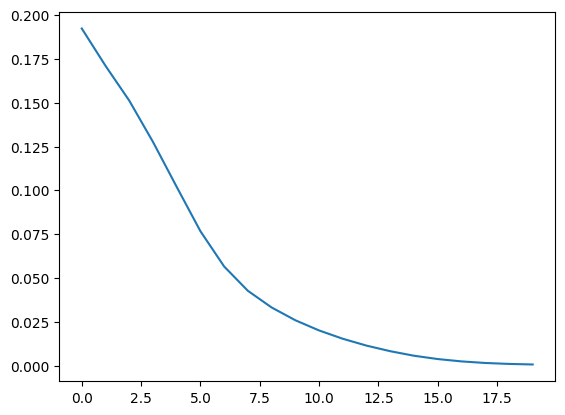

In [ ]:
plt.plot(training_loss)

In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(train))

100%|██████████| 194/194 [00:01<00:00, 106.40it/s]

Accuracy= 0.9998385273696109


In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(test_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(test))

100%|██████████| 65/65 [00:00<00:00, 91.72it/s]

Accuracy= 0.12736077481840194


## 小類分類：TextCNN 2
增加保留的詞性，但效果更差

In [ ]:
df_sample_1 = pd.read_csv('/content/drive/MyDrive/df_sample_1.csv')
df_sample_1.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
def NaNbNcNvA(product_cut): # 保留：Na普通名詞、Nb專有名詞、Nc地方詞、Nv動作詞、A形容詞
  words = product_cut.split()
  if any("#Na" in x or "#Nb" in x or "#Nc" in x or "#Nv" in x or "#A" in x for x in words):
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words if "#Na" in x or "#Nb" in x or "#Nc" in x or "#Nv" in x or "#A" in x) # 如：木紋#Na
      if sum([len(x)!=1 for x in result.split()])==0: # 如：非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na
          result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  else:
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  return(result)

print(NaNbNcNvA(df_sample_1['product_cut'][0]))
print(NaNbNcNvA('閃閃#VH 立體#VH 打亮#VC 刷#VC 入#VCL 小三美#VH 日#Nd'))
print(NaNbNcNvA('非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na'))

歐新力奇 木紋 咖啡機 手 廠商
閃閃 立體 打亮 刷 入 小三美 日
非 臘 不可 輕感 塑型 臘


In [ ]:
df_sample_1['product_cut_filter'] = df_sample_1['product_cut'].apply(lambda x: NaNbNcNvA(str(x)))
df_sample_1.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_filter
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,歐新力奇 木紋 咖啡機 手 廠商
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,日本 職人級 咖啡機 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 磨豆機 現貨 廠商
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,禾聯 人 份 自動式 咖啡機
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,新格 時尚 檯燈 現貨 廠商


In [ ]:
df_sample_1 = df_sample_1.replace('', np.NaN) # 將空值替換為NaN
product_nan = df_sample_1[df_sample_1['product_cut_filter'].isna()==True].index.tolist()
#print('篩選詞性後，共有',len(product_nan),'個product為空值(其中有',len(df_sample.loc[(product_nan)][df_sample['大類']=='書籍及雜誌期刊']),'個是書籍類)')
print('篩選詞性後，共有',len(product_nan),'個product為空值')

篩選詞性後，共有 0 個product為空值


In [ ]:
train,test = train_test_split(df_sample_1[['product_cut_filter','大類-小類']])

print('train.shape=',train.shape)
print('test.shape=',test.shape)

train.shape= (6191, 2)
test.shape= (2064, 2)


In [ ]:
train.head()

,product_cut_filter,大類-小類
182,優派 口袋 微型 投影機,家用電器-投影機/投影布幕
1505,鬼 刃 兄妹 針織 短褲 童裝 美人網,嬰幼兒童裝童鞋-短褲
6276,積木 海盜 寶藏島 運費,母嬰用品-積木玩具
619,巴黎 萊雅 活力 積雪草 奇蹟露,美妝保養-化妝水
4726,條紋 袖口 短袖 上衣,女生衣著-T恤


In [ ]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

TEXT = Field(lower=True, include_lengths=True,fix_length=1000, batch_first=True)
LABEL = Field(sequential=False)
fields = {'product_cut_filter': ('text',TEXT),'大類-小類': ('label',LABEL)}

train, test = TabularDataset.splits(path='/content/',
                                    train='train.csv',
                                    test='test.csv',
                                    format='csv',
                                    fields=fields)

TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, test_iter = BucketIterator.splits((train, test), batch_size=32, device=0,sort=False)

In [ ]:
class TextCNN(nn.Module):

    def __init__(self, embed_dim = 128, kernel_size=[2,3,4]):
        super(TextCNN,self).__init__()
        self.kernel_size = kernel_size

        self.embed = nn.Embedding(len(TEXT.vocab),embed_dim)
        self.cnn = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1,32,(kernel,embed_dim)),
                nn.LeakyReLU()
            )
            for kernel in kernel_size
        ])
        self.fc = nn.Linear(32*len(kernel_size),len(LABEL.vocab))

    def forward(self,x):
        tmp = self.embed(x).unsqueeze(1) # Batch_size, channel_number, Seq_len, embed_dim
        tmp = [c(tmp).squeeze(3) for c in self.cnn] # Batch_size, filter_number, Width
        tmp = [F.max_pool1d(t,t.size(2)).squeeze(2) for t in tmp] # Batch_size, filter_number
        tmp = torch.cat(tmp,1)
        tmp = self.fc(tmp)

        return tmp

In [ ]:
model = TextCNN().cuda()

In [ ]:
## 測試 forward
for i in train_iter:
    text = i.text[0].cuda()
    output = model(text)
    print(output.shape)
    break

torch.Size([32, 704])


In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [ ]:
epoches = 20
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = data.label.cuda()-1

        output = model(text)

        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward(retain_graph=True)
        optim.step()

        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

100%|██████████| 194/194 [00:06<00:00, 29.09it/s]


epoch 1 : 0.18935027636227786


100%|██████████| 194/194 [00:05<00:00, 36.63it/s]


epoch 2 : 0.15847360057642879


100%|██████████| 194/194 [00:05<00:00, 33.12it/s]


epoch 3 : 0.13039080731954622


100%|██████████| 194/194 [00:05<00:00, 34.54it/s]


epoch 4 : 0.10130495047688658


100%|██████████| 194/194 [00:05<00:00, 37.13it/s]


epoch 5 : 0.07203441476074796


100%|██████████| 194/194 [00:05<00:00, 32.95it/s]


epoch 6 : 0.046384797739763096


100%|██████████| 194/194 [00:05<00:00, 34.63it/s]


epoch 7 : 0.02751120991380279


100%|██████████| 194/194 [00:05<00:00, 36.79it/s]


epoch 8 : 0.01612801561253923


100%|██████████| 194/194 [00:06<00:00, 32.04it/s]


epoch 9 : 0.010028017093620783


100%|██████████| 194/194 [00:05<00:00, 35.13it/s]


epoch 10 : 0.006869543882327865


100%|██████████| 194/194 [00:05<00:00, 36.24it/s]


epoch 11 : 0.004964084349881946


100%|██████████| 194/194 [00:06<00:00, 30.98it/s]


epoch 12 : 0.003730090959603847


100%|██████████| 194/194 [00:05<00:00, 35.90it/s]


epoch 13 : 0.002944059092614651


100%|██████████| 194/194 [00:05<00:00, 36.69it/s]


epoch 14 : 0.0024248828238652223


100%|██████████| 194/194 [00:06<00:00, 31.08it/s]


epoch 15 : 0.0019582726852313955


100%|██████████| 194/194 [00:05<00:00, 36.48it/s]


epoch 16 : 0.0016404887022905773


100%|██████████| 194/194 [00:05<00:00, 36.38it/s]


epoch 17 : 0.0013846959201178264


100%|██████████| 194/194 [00:06<00:00, 31.27it/s]


epoch 18 : 0.001220209697483189


100%|██████████| 194/194 [00:05<00:00, 36.61it/s]


epoch 19 : 0.001047891780912775


100%|██████████| 194/194 [00:05<00:00, 35.76it/s]

epoch 20 : 0.0010666784279360138


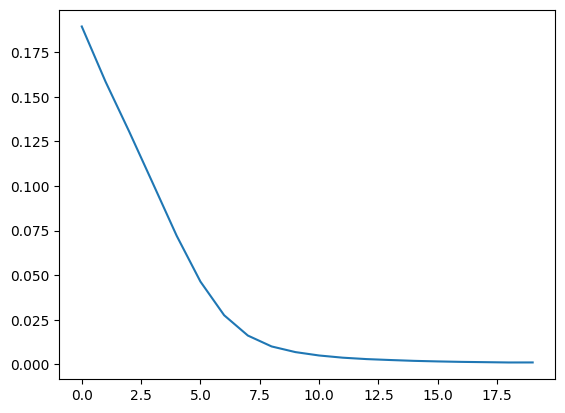

In [ ]:
plt.plot(training_loss)

In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(train))

100%|██████████| 194/194 [00:03<00:00, 63.27it/s]

Accuracy= 0.9953157809723793


In [ ]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(test_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print('Accuracy=',running_hit/len(test))

100%|██████████| 65/65 [00:00<00:00, 88.21it/s]

Accuracy= 0.3444767441860465


## 小類分類：TFIDF + SVM

In [ ]:
df_sample = pd.read_csv('/content/drive/MyDrive/df_sample_1.csv')
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...


In [ ]:
def NaNb(product_cut):
  words = product_cut.split()
  if any("#Na" in x or "#Nb" in x for x in words):
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words if "#Na" in x or "#Nb" in x) # 如：木紋#Na
      if sum([len(x)!=1 for x in result.split()])==0: # 如：非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na
          result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  else:
      result = " ".join(re.sub(r'#\w+\s*', "", x) for x in words)
  return(result)

print(NaNb(df_sample['product_cut'][0]))
print(NaNb('閃閃#VH 立體#VH 打亮#VC 刷#VC 入#VCL 小三美#VH 日#Nd'))
print(NaNb('非#A 臘#Na 不可#D 輕感#VH 塑型#VB 臘#Na'))

歐新力奇 木紋 咖啡機 手 廠商
閃閃 立體 打亮 刷 入 小三美 日
非 臘 不可 輕感 塑型 臘


In [ ]:
df_sample['product_cut_filter'] = df_sample['product_cut'].apply(lambda x: NaNb(str(x)))
df_sample.head()

,商品名稱,大類,小類,大類-小類,product_cut,product_cut_filter
0,OCEANRICH歐新力奇 S2 木紋便攜旋轉咖啡機 手沖 不插電 露營 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,OCEANRICH#FW 歐新力奇#Nb S2#FW 木紋#Na 便攜#D 旋轉#VAC 咖...,歐新力奇 木紋 咖啡機 手 廠商
1,TWINBIRD 日本職人級全自動手沖咖啡機 CM-D457TW 【全國電子】,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,TWINBIRD#FW 日本#Nc 職人級#Na 全自動#VH 手沖#VC 咖啡機#Na C...,職人級 咖啡機 全國 電子
2,小飛馬復古半磅磨豆機 600N 現貨 廠商直送,家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,小飛馬#Nb 復古#VH 半#Neqa 磨豆機#Na 600#FW 現貨#Na 廠商#Na ...,小飛馬 磨豆機 現貨 廠商
3,HERAN 禾聯 六人份自動式研磨咖啡機HCM-09C8(S),家用電器,咖啡機與周邊,家用電器-咖啡機與周邊,HERAN#FW 禾聯#Nb 人#Na 份#Na 自動式#Na 研磨#VC 咖啡機#Na H...,禾聯 人 份 自動式 咖啡機
4,SYNCO新格 LED4.5W輕巧時尚檯燈 SLD-045L 現貨 廠商直送,家用電器,其他家電,家用電器-其他家電,SYNCO#FW 新格#Na LED#FW W#FW 輕巧#VH 時尚#Na 檯燈#Na S...,新格 時尚 檯燈 現貨 廠商


In [ ]:
texts = tuple(df_sample["product_cut_filter"])
labels = tuple(df_sample["大類-小類"])

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# 將文本轉換為 TF-IDF 特徵
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [ ]:
X_train

<6604x9115 sparse matrix of type '<class 'numpy.float64'>'
	with 27731 stored elements in Compressed Sparse Row format>

In [ ]:
#导入数据集预处理、特征工程和模型训练所需的库
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
#创建一个dataframe，列名为text和label
df_sample["product_cut_filter"] = texts
df_sample["大類-小類"] = labels

#trainDF = pandas.DataFrame()
#trainDF['text'] = texts
#trainDF['label'] = labels

In [ ]:
#将数据集分为训练集和验证集
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_sample["product_cut_filter"], df_sample["大類-小類"])

# label编码为目标变量
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [ ]:
train_x

1517            氣墊 運動鞋 黑橘 童鞋
6226               恆溫感 背心 運費
1679    鏡頭 玻璃 鏡頭 鏡頭 鏡頭 現貨 廠商
2933            黃阿瑪 生活 陶瓷 杯墊
101             三洋 單槽 洗衣機 折扣
                ...         
2380               一体感 皮革 座墊
7222       愛普士 濃湯 單 機能 餐包 餐包
570                    身體 精油
3576        休閒鞋 板鞋 麂皮 變形蟲 紅色
4652          彈性 窄管 牛仔褲 女 淺藍
Name: product_cut_filter, Length: 6191, dtype: object

In [ ]:
train_y

array([112, 453, 340, ..., 623, 311,  63])

In [ ]:
#创建一个向量计数器对象
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(texts)

#使用向量计数器对象转换训练集和验证集
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [ ]:
#词语级tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(texts)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram 级tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(texts)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

#词性级tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(texts)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x)
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
  # fit the training dataset on the classifier
  classifier.fit(feature_vector_train, label)

  # predict the labels on validation dataset
  predictions = classifier.predict(feature_vector_valid)

  if is_neural_net:
    predictions = predictions.argmax(axis=-1)

  return metrics.accuracy_score(predictions, valid_y)

In [ ]:
#特征为多个词语级别TF-IDF向量的SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.003391472868217054


In [ ]:
#特征为计数向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print( "NB, Count Vectors: ", accuracy)

#特征为词语级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

#特征为多个词语级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

#特征为词性级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.009205426356589148
NB, WordLevel TF-IDF:  0.006298449612403101
NB, N-Gram Vectors:  0.0024224806201550387
NB, CharLevel Vectors:  0.009689922480620155


In [ ]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(xtrain_tfidf_ngram, train_y)
y_pred = clf.predict(xvalid_tfidf_ngram)
print(accuracy_score(valid_y, y_pred))

0.0014534883720930232
